# Simple grokking demo with superposition

In [1]:
# Import stuff
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import einops

## Generate Dataset

In [2]:
# Setup
p = 97
train_frac  = 0.3
device = t.accelerator.current_accelerator().type if t.accelerator.is_available() else "cpu"
device = "cpu"  # for the experiment we use cpu since mps cannot deal with float 64 apparently
print(f"Using {device} device")

Using cpu device


In [ ]:
a_vec = einops.repeat(t.arange(p),"i -> (i j)",j=p)
b_vec = einops.repeat(t.arange(p),"j -> (i j)",i=p)
eq_vec = einops.repeat(t.tensor(p)," -> i",i= p**2)
# The dataset consists of pairs (x,y) with x = (a,b,eq) and y = a+b mod p
# we randomly permute the dataset and split it into train and test dataset
dataset = t.stack([a_vec,b_vec,eq_vec],dim=1).to(device=device)
labels = (dataset[:,0] + dataset[:,1]) % p
indices = t.randperm(p**2)
train_indices = indices[:int(train_frac*p**2)]
test_indices = indices[int(train_frac*p**2):]

train_dataset = dataset[train_indices]
train_labels = labels[train_indices]

test_dataset = dataset[test_indices]
test_labels = labels[test_indices]
print(train_dataset)
print(train_labels)

tensor([[35, 51],
        [40, 50],
        [69, 89],
        ...,
        [62,  1],
        [ 3, 44],
        [51,  7]])
tensor([86, 90, 61,  ..., 63, 47, 58])


## Create a simple one layer transformer model

This is sort of the easiest possible transformer model. It takes as input the one hot encoded token sequence (a,b,=), where = is set to p for convenience. The architecture is:

0. Token: the tokens $t_0,t_1,t_2$ are one hot encoded d_vocab dimensional vectors and the input sequence is $$t = (t_0,t_1,t_2)^T$$
1. Embedding: The tokens are embedded in the d_model dimensional space by a learnable matrix W_E $$x_0 = Embed(t) = t @W_E$$
2. Positional Embedding: The positional Embedding is implemented by adding a d_model dimensional vector to each embedded vector, depending on the token position. It is also learned. $$x_1 = x_0 + W_{pos}$$
3. Attention layer: A simple attention layer with num_heads = 4 attention heads
$$x_2 = x_1 + Attention(x_1)$$
4. MLP layer: A simple mlp with one hidden layer with ReLU activation function and no bias:
$$x_3 = x_2 + MLP(x_2)$$
5. Unembedding: a learned unembedding matrix W_U that maps back to the vocab.
$$x_4 = x_3 @ W_U$$

In [4]:
#Config for the transformer architecture
d_vocab = p+1   #The input consists of the numbers from 0 to p-1 and p for the equal sign
d_model = 128   #dimension of the model
n_ctx = 3       #context length (a,b,=) where = is encoded as 97
num_heads = 4
d_heads = d_model//num_heads
d_mlp = 4 * d_model
act_type = "ReLU"   #or GeLU

In [71]:
from models.one_layer_transformer import Transformer

In [72]:
model = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)


## Training

In [73]:
from torch.utils.data import DataLoader, TensorDataset

import tqdm.auto as tqdm

In [6]:
#training parameters
n_epoch = 20000
lr = 1e-3
wd = 1.
DATA_SEED = 346
betas = (0.9,0.98)

In [144]:
# Define optimizer
optimizer = t.optim.AdamW(model.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [7]:
#Define cross entropy loss
def loss_fn(logits,labels):
    if len(logits.shape) == 3:
        logits = logits[:,-1]
    logits = logits.to(t.float64)   #change to 64 to prevent slingshots
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1,index = labels[:,None])[:,0]
    return -correct_log_probs.mean()

In [146]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with t.inference_mode():
        test_logits = model(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 101/20000 [00:09<31:38, 10.48it/s]

Epoch 99 Train Loss 1.2666997487333866 Test loss 8.411259522356021


  1%|          | 201/20000 [00:17<28:06, 11.74it/s]

Epoch 199 Train Loss 0.013061250183696466 Test loss 12.797173911561279


  2%|▏         | 301/20000 [00:26<28:32, 11.50it/s]

Epoch 299 Train Loss 0.004398469573854232 Test loss 12.945929219563329


  2%|▏         | 401/20000 [00:35<27:29, 11.88it/s]

Epoch 399 Train Loss 0.0014184029524277183 Test loss 13.390763289585756


  3%|▎         | 501/20000 [00:43<27:37, 11.77it/s]

Epoch 499 Train Loss 0.0004674039734725697 Test loss 13.9547700474295


  3%|▎         | 601/20000 [00:52<27:35, 11.72it/s]

Epoch 599 Train Loss 0.00015649983123786998 Test loss 14.577979794924444


  4%|▎         | 701/20000 [01:01<29:37, 10.85it/s]

Epoch 699 Train Loss 5.305277254906984e-05 Test loss 15.232881763157351


  4%|▍         | 801/20000 [01:10<28:24, 11.26it/s]

Epoch 799 Train Loss 1.8340863587030924e-05 Test loss 15.887154472998231


  5%|▍         | 901/20000 [01:19<28:36, 11.13it/s]

Epoch 899 Train Loss 6.556522486920984e-06 Test loss 16.520036827127413


  5%|▌         | 1001/20000 [01:27<27:06, 11.68it/s]

Epoch 999 Train Loss 2.489279159146624e-06 Test loss 17.07678975762812


  6%|▌         | 1101/20000 [01:36<27:46, 11.34it/s]

Epoch 1099 Train Loss 1.059968293129914e-06 Test loss 17.521347452448776


  6%|▌         | 1201/20000 [01:45<27:43, 11.30it/s]

Epoch 1199 Train Loss 5.419272004646735e-07 Test loss 17.789016339179028


  7%|▋         | 1301/20000 [01:54<25:21, 12.29it/s]

Epoch 1299 Train Loss 3.495252936142206e-07 Test loss 17.848134622971706


  7%|▋         | 1401/20000 [02:03<26:31, 11.69it/s]

Epoch 1399 Train Loss 2.8034611765085524e-07 Test loss 17.71796045863827


  8%|▊         | 1501/20000 [02:13<32:00,  9.63it/s]

Epoch 1499 Train Loss 2.597862694554152e-07 Test loss 17.46055433893886


  8%|▊         | 1601/20000 [02:23<28:15, 10.85it/s]

Epoch 1599 Train Loss 2.547101309555959e-07 Test loss 17.152410388985274


  9%|▊         | 1701/20000 [02:33<30:15, 10.08it/s]

Epoch 1699 Train Loss 2.53052022563147e-07 Test loss 16.822652234322355


  9%|▉         | 1800/20000 [02:43<30:45,  9.86it/s]

Epoch 1799 Train Loss 2.5191669170510645e-07 Test loss 16.485592285814278


 10%|▉         | 1902/20000 [02:51<25:14, 11.95it/s]

Epoch 1899 Train Loss 2.505174108897684e-07 Test loss 16.137022392301272


 10%|█         | 2000/20000 [03:00<28:06, 10.68it/s]

Epoch 1999 Train Loss 2.487757606047507e-07 Test loss 15.78590920888386


 11%|█         | 2102/20000 [03:08<24:44, 12.06it/s]

Epoch 2099 Train Loss 2.4694222745027233e-07 Test loss 15.415014100669616


 11%|█         | 2202/20000 [03:17<25:44, 11.52it/s]

Epoch 2199 Train Loss 2.4481809053982204e-07 Test loss 15.026867608549795


 12%|█▏        | 2302/20000 [03:26<24:55, 11.83it/s]

Epoch 2299 Train Loss 2.426926738827643e-07 Test loss 14.613334535783915


 12%|█▏        | 2400/20000 [03:35<24:24, 12.02it/s]

Epoch 2399 Train Loss 2.405306106203388e-07 Test loss 14.176757767627288


 13%|█▎        | 2502/20000 [03:43<23:58, 12.16it/s]

Epoch 2499 Train Loss 2.3819774786005357e-07 Test loss 13.711444960379376


 13%|█▎        | 2602/20000 [03:52<24:35, 11.79it/s]

Epoch 2599 Train Loss 2.3568451476075358e-07 Test loss 13.211903704490457


 14%|█▎        | 2702/20000 [04:00<23:50, 12.09it/s]

Epoch 2699 Train Loss 2.3323676800133814e-07 Test loss 12.677221030850582


 14%|█▍        | 2802/20000 [04:09<24:03, 11.92it/s]

Epoch 2799 Train Loss 2.3093147315432537e-07 Test loss 12.122023965064688


 15%|█▍        | 2902/20000 [04:17<23:41, 12.03it/s]

Epoch 2899 Train Loss 2.2838108765865704e-07 Test loss 11.537134545888932


 15%|█▌        | 3002/20000 [04:26<24:23, 11.61it/s]

Epoch 2999 Train Loss 2.256157675109001e-07 Test loss 10.918463019036736


 16%|█▌        | 3102/20000 [04:34<23:27, 12.01it/s]

Epoch 3099 Train Loss 2.2305392408529182e-07 Test loss 10.260690730556338


 16%|█▌        | 3202/20000 [04:43<23:35, 11.86it/s]

Epoch 3199 Train Loss 2.1987118835838162e-07 Test loss 9.54992667424061


 17%|█▋        | 3301/20000 [04:51<23:18, 11.94it/s]

Epoch 3299 Train Loss 2.1661438957521784e-07 Test loss 8.790517013582411


 17%|█▋        | 3402/20000 [08:01<13:19:52,  2.89s/it] 

Epoch 3399 Train Loss 2.130361401385147e-07 Test loss 7.977359160106436


 18%|█▊        | 3501/20000 [08:10<30:30,  9.01it/s]   

Epoch 3499 Train Loss 2.0912258731074695e-07 Test loss 7.11019118935425


 18%|█▊        | 3602/20000 [08:18<22:05, 12.37it/s]

Epoch 3599 Train Loss 2.046672767410747e-07 Test loss 6.202799737694649


 19%|█▊        | 3702/20000 [08:27<22:29, 12.08it/s]

Epoch 3699 Train Loss 1.9984749276160807e-07 Test loss 5.254412040809342


 19%|█▉        | 3802/20000 [08:35<21:56, 12.30it/s]

Epoch 3799 Train Loss 1.9441808775566262e-07 Test loss 4.293332867636127


 20%|█▉        | 3902/20000 [08:43<22:08, 12.11it/s]

Epoch 3899 Train Loss 1.8801460111841623e-07 Test loss 3.3331127799632028


 20%|██        | 4001/20000 [08:52<26:11, 10.18it/s]

Epoch 3999 Train Loss 1.809947827400558e-07 Test loss 2.431754572815123


 21%|██        | 4101/20000 [09:01<22:25, 11.82it/s]

Epoch 4099 Train Loss 1.7347423514333337e-07 Test loss 1.6453127993085905


 21%|██        | 4201/20000 [09:09<21:36, 12.19it/s]

Epoch 4199 Train Loss 1.6572247502565905e-07 Test loss 1.0186502875828691


 22%|██▏       | 4301/20000 [09:17<21:44, 12.03it/s]

Epoch 4299 Train Loss 1.57198736163554e-07 Test loss 0.576672137370089


 22%|██▏       | 4401/20000 [09:26<22:46, 11.41it/s]

Epoch 4399 Train Loss 1.4898948915991411e-07 Test loss 0.29997032077247154


 23%|██▎       | 4501/20000 [09:36<22:23, 11.54it/s]

Epoch 4499 Train Loss 1.4067441314166824e-07 Test loss 0.14358660462583234


 23%|██▎       | 4602/20000 [09:46<22:11, 11.57it/s]

Epoch 4599 Train Loss 1.3240533049786437e-07 Test loss 0.06407145708574735


 24%|██▎       | 4702/20000 [09:54<21:03, 12.11it/s]

Epoch 4699 Train Loss 1.248257179929465e-07 Test loss 0.027123058211955573


 24%|██▍       | 4802/20000 [10:03<20:40, 12.25it/s]

Epoch 4799 Train Loss 1.1831368968039183e-07 Test loss 0.009820477947245318


 25%|██▍       | 4902/20000 [10:11<20:46, 12.12it/s]

Epoch 4899 Train Loss 1.1296817658073337e-07 Test loss 0.0023613391497716535


 25%|██▌       | 5002/20000 [10:20<20:46, 12.03it/s]

Epoch 4999 Train Loss 1.0874723985082967e-07 Test loss 0.0005584818852223097


 26%|██▌       | 5102/20000 [10:28<20:22, 12.18it/s]

Epoch 5099 Train Loss 1.0525280418600331e-07 Test loss 0.00018110246650692954


 26%|██▌       | 5202/20000 [10:36<20:33, 11.99it/s]

Epoch 5199 Train Loss 1.0282348299968983e-07 Test loss 6.0972827436283334e-05


 27%|██▋       | 5302/20000 [10:45<20:13, 12.11it/s]

Epoch 5299 Train Loss 1.0104200197262233e-07 Test loss 2.218141256756692e-05


 27%|██▋       | 5402/20000 [10:53<20:08, 12.08it/s]

Epoch 5399 Train Loss 9.974943150859726e-08 Test loss 9.34858761727351e-06


 28%|██▊       | 5502/20000 [11:01<19:56, 12.11it/s]

Epoch 5499 Train Loss 9.870765480024036e-08 Test loss 4.494982993429224e-06


 28%|██▊       | 5602/20000 [11:10<19:56, 12.04it/s]

Epoch 5599 Train Loss 9.787145201246989e-08 Test loss 2.484180585976654e-06


 29%|██▊       | 5702/20000 [11:18<19:44, 12.07it/s]

Epoch 5699 Train Loss 9.709927373963031e-08 Test loss 1.5464889005622743e-06


 29%|██▉       | 5802/20000 [11:27<19:27, 12.16it/s]

Epoch 5799 Train Loss 9.634509432483008e-08 Test loss 1.0160162053706245e-06


 30%|██▉       | 5902/20000 [11:35<20:12, 11.63it/s]

Epoch 5899 Train Loss 9.5567715822753e-08 Test loss 7.087505725156607e-07


 30%|███       | 6001/20000 [11:44<31:16,  7.46it/s]

Epoch 5999 Train Loss 9.482030554076086e-08 Test loss 5.42701091553234e-07


 31%|███       | 6101/20000 [11:53<19:24, 11.94it/s]

Epoch 6099 Train Loss 9.409257691358239e-08 Test loss 4.521654558362478e-07


 31%|███       | 6201/20000 [12:01<19:15, 11.94it/s]

Epoch 6199 Train Loss 9.345261221880484e-08 Test loss 3.9415672767271544e-07


 32%|███▏      | 6301/20000 [12:11<20:31, 11.12it/s]

Epoch 6299 Train Loss 9.288406321473969e-08 Test loss 3.5380061400352986e-07


 32%|███▏      | 6400/20000 [12:20<21:34, 10.51it/s]

Epoch 6399 Train Loss 9.2424316402343e-08 Test loss 3.231693627342731e-07


 33%|███▎      | 6502/20000 [12:29<18:54, 11.90it/s]

Epoch 6499 Train Loss 9.204149926792046e-08 Test loss 3.0111395969219627e-07


 33%|███▎      | 6602/20000 [12:37<18:25, 12.12it/s]

Epoch 6599 Train Loss 9.172538276553053e-08 Test loss 2.8439090506937165e-07


 34%|███▎      | 6702/20000 [12:46<18:34, 11.94it/s]

Epoch 6699 Train Loss 9.147609532446909e-08 Test loss 2.719597257377913e-07


 34%|███▍      | 6801/20000 [12:54<18:28, 11.91it/s]

Epoch 6799 Train Loss 9.126177174520973e-08 Test loss 2.618903821475605e-07


 35%|███▍      | 6901/20000 [13:03<18:34, 11.76it/s]

Epoch 6899 Train Loss 9.106955569080993e-08 Test loss 2.5355183921625703e-07


 35%|███▌      | 7002/20000 [13:12<18:27, 11.74it/s]

Epoch 6999 Train Loss 9.090622111481293e-08 Test loss 2.4653192999804297e-07


 36%|███▌      | 7100/20000 [13:20<17:46, 12.10it/s]

Epoch 7099 Train Loss 9.073932441513315e-08 Test loss 2.4127759845660547e-07


 36%|███▌      | 7202/20000 [13:29<18:24, 11.59it/s]

Epoch 7199 Train Loss 9.06047797242107e-08 Test loss 2.3718521799923615e-07


 37%|███▋      | 7302/20000 [13:37<17:50, 11.86it/s]

Epoch 7299 Train Loss 9.045891036318991e-08 Test loss 2.3396831523125495e-07


 37%|███▋      | 7401/20000 [13:46<17:39, 11.89it/s]

Epoch 7399 Train Loss 9.034120920779528e-08 Test loss 2.3112889068525987e-07


 38%|███▊      | 7501/20000 [13:55<17:50, 11.68it/s]

Epoch 7499 Train Loss 9.022705371426191e-08 Test loss 2.2890583394707874e-07


 38%|███▊      | 7601/20000 [14:03<17:20, 11.91it/s]

Epoch 7599 Train Loss 9.011929472807243e-08 Test loss 2.2727501175897875e-07


 39%|███▊      | 7702/20000 [14:13<18:02, 11.37it/s]

Epoch 7699 Train Loss 9.00216010259575e-08 Test loss 2.261684587527055e-07


 39%|███▉      | 7802/20000 [14:21<17:03, 11.92it/s]

Epoch 7799 Train Loss 8.99320192913525e-08 Test loss 2.2530365279593748e-07


 40%|███▉      | 7901/20000 [14:30<16:58, 11.88it/s]

Epoch 7899 Train Loss 8.985568773455503e-08 Test loss 2.2460491375200807e-07


 40%|████      | 8001/20000 [14:39<17:21, 11.52it/s]

Epoch 7999 Train Loss 8.977676076225464e-08 Test loss 2.2399296903664869e-07


 41%|████      | 8102/20000 [14:48<20:47,  9.54it/s]

Epoch 8099 Train Loss 8.970313872282201e-08 Test loss 2.2368666432129138e-07


 41%|████      | 8202/20000 [14:56<16:37, 11.83it/s]

Epoch 8199 Train Loss 8.963554479338812e-08 Test loss 2.2326678336397434e-07


 42%|████▏     | 8302/20000 [15:05<17:19, 11.25it/s]

Epoch 8299 Train Loss 8.956880865708497e-08 Test loss 2.230397067035963e-07


 42%|████▏     | 8402/20000 [15:14<17:38, 10.96it/s]

Epoch 8399 Train Loss 8.950726751793668e-08 Test loss 2.2289939826110082e-07


 43%|████▎     | 8502/20000 [15:23<15:42, 12.20it/s]

Epoch 8499 Train Loss 8.94495711311674e-08 Test loss 2.2280007336783016e-07


 43%|████▎     | 8602/20000 [15:31<15:45, 12.05it/s]

Epoch 8599 Train Loss 8.938732106380334e-08 Test loss 2.2247496518835206e-07


 44%|████▎     | 8702/20000 [15:40<15:28, 12.17it/s]

Epoch 8699 Train Loss 8.932956404243763e-08 Test loss 2.2255374150960637e-07


 44%|████▍     | 8802/20000 [15:48<15:44, 11.85it/s]

Epoch 8799 Train Loss 8.927971325720099e-08 Test loss 2.2284095088699777e-07


 45%|████▍     | 8902/20000 [15:56<16:11, 11.43it/s]

Epoch 8899 Train Loss 8.923191398476403e-08 Test loss 2.230736153037521e-07


 45%|████▌     | 9002/20000 [16:05<15:29, 11.83it/s]

Epoch 8999 Train Loss 8.91808042379477e-08 Test loss 2.2318508047271458e-07


 46%|████▌     | 9102/20000 [16:14<17:03, 10.65it/s]

Epoch 9099 Train Loss 8.913281525286366e-08 Test loss 2.2337822609106219e-07


 46%|████▌     | 9202/20000 [16:23<15:05, 11.93it/s]

Epoch 9199 Train Loss 8.909061473708909e-08 Test loss 2.235365086045765e-07


 47%|████▋     | 9302/20000 [16:31<14:46, 12.07it/s]

Epoch 9299 Train Loss 8.904721745588184e-08 Test loss 2.2369991056608712e-07


 47%|████▋     | 9402/20000 [16:40<15:05, 11.70it/s]

Epoch 9399 Train Loss 8.900534689839362e-08 Test loss 2.239666733179347e-07


 48%|████▊     | 9501/20000 [16:50<17:57,  9.75it/s]

Epoch 9499 Train Loss 8.89634112802271e-08 Test loss 2.2418135932005547e-07


 48%|████▊     | 9600/20000 [16:59<14:47, 11.72it/s]

Epoch 9599 Train Loss 8.892750248946141e-08 Test loss 2.2446966830245393e-07


 49%|████▊     | 9702/20000 [17:09<14:07, 12.16it/s]

Epoch 9699 Train Loss 8.888828417281364e-08 Test loss 2.2479973432162007e-07


 49%|████▉     | 9802/20000 [17:18<14:00, 12.13it/s]

Epoch 9799 Train Loss 8.885148601346168e-08 Test loss 2.2510371292415664e-07


 50%|████▉     | 9902/20000 [17:26<13:52, 12.13it/s]

Epoch 9899 Train Loss 8.881498166107283e-08 Test loss 2.2539447182959574e-07


 50%|█████     | 10002/20000 [17:35<13:50, 12.04it/s]

Epoch 9999 Train Loss 8.877864732028464e-08 Test loss 2.257916354387088e-07


 51%|█████     | 10102/20000 [17:43<13:35, 12.14it/s]

Epoch 10099 Train Loss 8.874402810003107e-08 Test loss 2.2611185876637216e-07


 51%|█████     | 10200/20000 [17:51<13:48, 11.83it/s]

Epoch 10199 Train Loss 8.871254648019889e-08 Test loss 2.263552687890426e-07


 52%|█████▏    | 10300/20000 [18:00<15:42, 10.30it/s]

Epoch 10299 Train Loss 8.868316004337429e-08 Test loss 2.266638548202143e-07


 52%|█████▏    | 10401/20000 [18:10<12:56, 12.35it/s]

Epoch 10399 Train Loss 8.864976612826308e-08 Test loss 2.268547754827133e-07


 53%|█████▎    | 10501/20000 [18:18<13:19, 11.88it/s]

Epoch 10499 Train Loss 8.861853254001837e-08 Test loss 2.270720365698148e-07


 53%|█████▎    | 10601/20000 [18:26<12:44, 12.30it/s]

Epoch 10599 Train Loss 8.859009532905353e-08 Test loss 2.273091765063858e-07


 54%|█████▎    | 10701/20000 [18:35<13:04, 11.86it/s]

Epoch 10699 Train Loss 8.856068905898599e-08 Test loss 2.2748759078028596e-07


 54%|█████▍    | 10801/20000 [18:43<12:21, 12.40it/s]

Epoch 10799 Train Loss 8.853042983666338e-08 Test loss 2.276460848986701e-07


 55%|█████▍    | 10901/20000 [18:51<12:26, 12.18it/s]

Epoch 10899 Train Loss 8.850465638010525e-08 Test loss 2.2788040437656775e-07


 55%|█████▌    | 11001/20000 [19:00<14:09, 10.60it/s]

Epoch 10999 Train Loss 8.847648466198538e-08 Test loss 2.2813392184361176e-07


 56%|█████▌    | 11101/20000 [19:08<12:21, 12.01it/s]

Epoch 11099 Train Loss 8.844963553203086e-08 Test loss 2.284083539375456e-07


 56%|█████▌    | 11202/20000 [19:17<12:11, 12.03it/s]

Epoch 11199 Train Loss 8.842447943807071e-08 Test loss 2.286230792339734e-07


 57%|█████▋    | 11302/20000 [19:25<13:01, 11.13it/s]

Epoch 11299 Train Loss 8.840187009719528e-08 Test loss 2.28884224850407e-07


 57%|█████▋    | 11402/20000 [19:34<11:58, 11.97it/s]

Epoch 11399 Train Loss 8.837984293153377e-08 Test loss 2.291387291105279e-07


 58%|█████▊    | 11502/20000 [19:42<12:05, 11.72it/s]

Epoch 11499 Train Loss 8.835797545137408e-08 Test loss 2.2936640798586764e-07


 58%|█████▊    | 11602/20000 [19:51<12:28, 11.22it/s]

Epoch 11599 Train Loss 8.833817229560334e-08 Test loss 2.2963987873872606e-07


 59%|█████▊    | 11702/20000 [19:59<11:36, 11.92it/s]

Epoch 11699 Train Loss 8.831682916424225e-08 Test loss 2.298342915856516e-07


 59%|█████▉    | 11802/20000 [20:08<12:44, 10.72it/s]

Epoch 11799 Train Loss 8.829587983388507e-08 Test loss 2.2996608972308155e-07


 60%|█████▉    | 11902/20000 [20:16<11:08, 12.11it/s]

Epoch 11899 Train Loss 8.827577675331455e-08 Test loss 2.3020100658474076e-07


 60%|██████    | 12002/20000 [20:25<11:18, 11.79it/s]

Epoch 11999 Train Loss 8.825489838523408e-08 Test loss 2.3035318471584875e-07


 61%|██████    | 12102/20000 [20:33<10:53, 12.09it/s]

Epoch 12099 Train Loss 8.823448275286604e-08 Test loss 2.3062338807062872e-07


 61%|██████    | 12202/20000 [20:42<10:47, 12.04it/s]

Epoch 12199 Train Loss 8.821426039344442e-08 Test loss 2.308551236708047e-07


 62%|██████▏   | 12302/20000 [20:50<10:43, 11.97it/s]

Epoch 12299 Train Loss 8.819550890473776e-08 Test loss 2.310196726453699e-07


 62%|██████▏   | 12402/20000 [20:58<10:25, 12.15it/s]

Epoch 12399 Train Loss 8.817902822754012e-08 Test loss 2.311639151881085e-07


 63%|██████▎   | 12502/20000 [21:07<10:20, 12.08it/s]

Epoch 12499 Train Loss 8.816019671834925e-08 Test loss 2.3136933377331348e-07


 63%|██████▎   | 12602/20000 [21:15<10:07, 12.18it/s]

Epoch 12599 Train Loss 8.814156258132707e-08 Test loss 2.3153831468767293e-07


 64%|██████▎   | 12700/20000 [21:23<10:27, 11.62it/s]

Epoch 12699 Train Loss 8.81264422727645e-08 Test loss 2.3169538976587061e-07


 64%|██████▍   | 12801/20000 [21:33<12:26,  9.64it/s]

Epoch 12799 Train Loss 8.81117624601489e-08 Test loss 2.3188485741443093e-07


 65%|██████▍   | 12902/20000 [21:43<10:16, 11.51it/s]

Epoch 12899 Train Loss 8.809521515545385e-08 Test loss 2.3208948485724154e-07


 65%|██████▌   | 13002/20000 [21:51<09:27, 12.34it/s]

Epoch 12999 Train Loss 8.808072156120748e-08 Test loss 2.3231603231841507e-07


 66%|██████▌   | 13102/20000 [22:00<09:37, 11.94it/s]

Epoch 13099 Train Loss 8.806581350310923e-08 Test loss 2.3244590084434883e-07


 66%|██████▌   | 13200/20000 [22:08<10:27, 10.84it/s]

Epoch 13199 Train Loss 8.805125091574213e-08 Test loss 2.3254083816975402e-07


 67%|██████▋   | 13302/20000 [22:18<09:10, 12.17it/s]

Epoch 13299 Train Loss 8.803583402582175e-08 Test loss 2.327604743034431e-07


 67%|██████▋   | 13402/20000 [22:27<09:43, 11.31it/s]

Epoch 13399 Train Loss 8.80221998363849e-08 Test loss 2.3293616385067315e-07


 68%|██████▊   | 13502/20000 [22:35<08:55, 12.13it/s]

Epoch 13499 Train Loss 8.800904029353347e-08 Test loss 2.3317762890713668e-07


 68%|██████▊   | 13602/20000 [22:44<09:28, 11.25it/s]

Epoch 13599 Train Loss 8.799494263357252e-08 Test loss 2.333714139115819e-07


 69%|██████▊   | 13702/20000 [22:52<08:38, 12.14it/s]

Epoch 13699 Train Loss 8.798269017146184e-08 Test loss 2.3350938906519074e-07


 69%|██████▉   | 13802/20000 [23:01<08:34, 12.06it/s]

Epoch 13799 Train Loss 8.796950216708235e-08 Test loss 2.337672420194447e-07


 70%|██████▉   | 13902/20000 [23:09<08:20, 12.18it/s]

Epoch 13899 Train Loss 8.79566915113273e-08 Test loss 2.3401362516651912e-07


 70%|███████   | 14002/20000 [23:17<08:14, 12.12it/s]

Epoch 13999 Train Loss 8.794485531810234e-08 Test loss 2.3420054481399322e-07


 71%|███████   | 14102/20000 [23:26<08:51, 11.11it/s]

Epoch 14099 Train Loss 8.793514633997113e-08 Test loss 2.344174559581426e-07


 71%|███████   | 14202/20000 [23:34<07:55, 12.19it/s]

Epoch 14199 Train Loss 8.792178701097753e-08 Test loss 2.3458903280392158e-07


 72%|███████▏  | 14302/20000 [23:43<07:54, 12.00it/s]

Epoch 14299 Train Loss 8.791265705756419e-08 Test loss 2.3491359192881534e-07


 72%|███████▏  | 14402/20000 [23:51<07:58, 11.69it/s]

Epoch 14399 Train Loss 8.789962440514867e-08 Test loss 2.3508459698280924e-07


 73%|███████▎  | 14502/20000 [24:00<07:54, 11.59it/s]

Epoch 14499 Train Loss 8.789047823036927e-08 Test loss 2.3533804777020536e-07


 73%|███████▎  | 14602/20000 [24:08<07:28, 12.04it/s]

Epoch 14599 Train Loss 8.788026242556092e-08 Test loss 2.3554281646397747e-07


 74%|███████▎  | 14700/20000 [24:17<07:25, 11.91it/s]

Epoch 14699 Train Loss 8.787001451393093e-08 Test loss 2.357948307712679e-07


 74%|███████▍  | 14802/20000 [24:25<07:11, 12.05it/s]

Epoch 14799 Train Loss 8.785958849544185e-08 Test loss 2.3597264859902473e-07


 75%|███████▍  | 14902/20000 [24:34<07:04, 12.02it/s]

Epoch 14899 Train Loss 8.784875381284322e-08 Test loss 2.3628470638236528e-07


 75%|███████▌  | 15002/20000 [24:42<07:03, 11.81it/s]

Epoch 14999 Train Loss 8.783858081846058e-08 Test loss 2.364948141376931e-07


 76%|███████▌  | 15102/20000 [24:51<07:50, 10.40it/s]

Epoch 15099 Train Loss 8.782953484981503e-08 Test loss 2.3666661036989214e-07


 76%|███████▌  | 15202/20000 [24:59<06:36, 12.10it/s]

Epoch 15199 Train Loss 8.782063050557481e-08 Test loss 2.369214716802057e-07


 77%|███████▋  | 15302/20000 [25:08<06:38, 11.79it/s]

Epoch 15299 Train Loss 8.781026402263814e-08 Test loss 2.3714231095236222e-07


 77%|███████▋  | 15401/20000 [25:17<06:32, 11.71it/s]

Epoch 15399 Train Loss 8.780075503729656e-08 Test loss 2.372892720700509e-07


 78%|███████▊  | 15501/20000 [25:25<06:11, 12.10it/s]

Epoch 15499 Train Loss 8.779266059826246e-08 Test loss 2.374367143657933e-07


 78%|███████▊  | 15601/20000 [25:34<06:08, 11.93it/s]

Epoch 15599 Train Loss 8.778347910832767e-08 Test loss 2.3761939976122152e-07


 79%|███████▊  | 15701/20000 [25:42<06:06, 11.72it/s]

Epoch 15699 Train Loss 8.777605722986599e-08 Test loss 2.3772033087054382e-07


 79%|███████▉  | 15801/20000 [25:50<06:03, 11.55it/s]

Epoch 15799 Train Loss 8.776671216579649e-08 Test loss 2.3787912611446527e-07


 80%|███████▉  | 15901/20000 [25:59<05:42, 11.95it/s]

Epoch 15899 Train Loss 8.77593996313194e-08 Test loss 2.3795185500367582e-07


 80%|████████  | 16001/20000 [26:07<05:27, 12.20it/s]

Epoch 15999 Train Loss 8.775195102573086e-08 Test loss 2.3804572174239953e-07


 81%|████████  | 16101/20000 [26:16<06:13, 10.44it/s]

Epoch 16099 Train Loss 8.77435007698049e-08 Test loss 2.3824363980526092e-07


 81%|████████  | 16201/20000 [26:24<05:15, 12.06it/s]

Epoch 16199 Train Loss 8.773755632002128e-08 Test loss 2.3833805460704827e-07


 82%|████████▏ | 16301/20000 [26:32<05:04, 12.16it/s]

Epoch 16299 Train Loss 8.772910834871122e-08 Test loss 2.3848937165753353e-07


 82%|████████▏ | 16401/20000 [26:41<04:56, 12.12it/s]

Epoch 16399 Train Loss 8.772384527062288e-08 Test loss 2.386839190458163e-07


 83%|████████▎ | 16501/20000 [26:49<04:49, 12.10it/s]

Epoch 16499 Train Loss 8.771479004626716e-08 Test loss 2.388524211033021e-07


 83%|████████▎ | 16601/20000 [26:57<04:38, 12.19it/s]

Epoch 16599 Train Loss 8.770731102362202e-08 Test loss 2.39077599536616e-07


 84%|████████▎ | 16701/20000 [27:06<04:32, 12.09it/s]

Epoch 16699 Train Loss 8.770236004949458e-08 Test loss 2.392479745231078e-07


 84%|████████▍ | 16801/20000 [27:14<04:19, 12.32it/s]

Epoch 16799 Train Loss 8.769506575192517e-08 Test loss 2.394569045246773e-07


 85%|████████▍ | 16901/20000 [27:22<04:22, 11.79it/s]

Epoch 16899 Train Loss 8.768806067530172e-08 Test loss 2.3966338399668456e-07


 85%|████████▌ | 17001/20000 [27:31<04:06, 12.16it/s]

Epoch 16999 Train Loss 8.76810384890446e-08 Test loss 2.3979453428181404e-07


 86%|████████▌ | 17101/20000 [27:39<04:01, 12.02it/s]

Epoch 17099 Train Loss 8.767479594336211e-08 Test loss 2.4001052557311466e-07


 86%|████████▌ | 17201/20000 [27:48<04:11, 11.11it/s]

Epoch 17199 Train Loss 8.766938820790896e-08 Test loss 2.4019859960606853e-07


 87%|████████▋ | 17301/20000 [27:56<03:48, 11.82it/s]

Epoch 17299 Train Loss 8.766193298347004e-08 Test loss 2.403606753893039e-07


 87%|████████▋ | 17401/20000 [28:05<03:33, 12.15it/s]

Epoch 17399 Train Loss 8.765695227120621e-08 Test loss 2.405629174517669e-07


 88%|████████▊ | 17501/20000 [28:13<03:31, 11.82it/s]

Epoch 17499 Train Loss 8.765134336636276e-08 Test loss 2.407918394024248e-07


 88%|████████▊ | 17601/20000 [28:22<03:17, 12.14it/s]

Epoch 17599 Train Loss 8.76451613325784e-08 Test loss 2.409688652280514e-07


 89%|████████▊ | 17701/20000 [28:30<03:09, 12.14it/s]

Epoch 17699 Train Loss 8.763995988569657e-08 Test loss 2.4107096952759384e-07


 89%|████████▉ | 17801/20000 [28:39<03:01, 12.14it/s]

Epoch 17799 Train Loss 8.763446759337107e-08 Test loss 2.411068522669396e-07


 90%|████████▉ | 17901/20000 [28:47<02:52, 12.20it/s]

Epoch 17899 Train Loss 8.76289522270866e-08 Test loss 2.4128837921734173e-07


 90%|█████████ | 18001/20000 [28:55<02:45, 12.05it/s]

Epoch 17999 Train Loss 8.76229950756693e-08 Test loss 2.41525917460418e-07


 91%|█████████ | 18101/20000 [29:04<02:44, 11.57it/s]

Epoch 18099 Train Loss 8.761823942375066e-08 Test loss 2.416992271346509e-07


 91%|█████████ | 18201/20000 [29:12<02:33, 11.75it/s]

Epoch 18199 Train Loss 8.760892287744577e-08 Test loss 2.41767269301759e-07


 92%|█████████▏| 18301/20000 [29:21<02:19, 12.16it/s]

Epoch 18299 Train Loss 8.760536137658992e-08 Test loss 2.4188246856817895e-07


 92%|█████████▏| 18401/20000 [29:29<02:12, 12.08it/s]

Epoch 18399 Train Loss 8.759849073766492e-08 Test loss 2.420641694773443e-07


 93%|█████████▎| 18501/20000 [29:38<02:06, 11.85it/s]

Epoch 18499 Train Loss 8.75921547159427e-08 Test loss 2.4221460448286905e-07


 93%|█████████▎| 18601/20000 [29:46<01:57, 11.94it/s]

Epoch 18599 Train Loss 8.758777649312025e-08 Test loss 2.423298323850403e-07


 94%|█████████▎| 18701/20000 [29:55<01:54, 11.35it/s]

Epoch 18699 Train Loss 8.758204485849544e-08 Test loss 2.4243158379684625e-07


 94%|█████████▍| 18801/20000 [30:03<01:40, 11.98it/s]

Epoch 18799 Train Loss 8.757816438292159e-08 Test loss 2.4254150967608134e-07


 95%|█████████▍| 18901/20000 [30:11<01:30, 12.12it/s]

Epoch 18899 Train Loss 8.757368016639175e-08 Test loss 2.4272631483947977e-07


 95%|█████████▌| 19002/20000 [30:20<01:23, 11.97it/s]

Epoch 18999 Train Loss 8.756820885723814e-08 Test loss 2.42857113364397e-07


 96%|█████████▌| 19102/20000 [30:29<01:22, 10.88it/s]

Epoch 19099 Train Loss 8.756313741846593e-08 Test loss 2.4293348130732403e-07


 96%|█████████▌| 19202/20000 [30:37<01:06, 11.93it/s]

Epoch 19199 Train Loss 8.756079706332206e-08 Test loss 2.430518918540545e-07


 97%|█████████▋| 19302/20000 [30:46<00:59, 11.81it/s]

Epoch 19299 Train Loss 8.755591824267315e-08 Test loss 2.4324989594117764e-07


 97%|█████████▋| 19402/20000 [30:54<00:50, 11.81it/s]

Epoch 19399 Train Loss 8.755044941506897e-08 Test loss 2.4333272432968706e-07


 98%|█████████▊| 19502/20000 [31:03<00:41, 11.89it/s]

Epoch 19499 Train Loss 8.754594388879597e-08 Test loss 2.434793794931087e-07


 98%|█████████▊| 19602/20000 [31:12<00:34, 11.65it/s]

Epoch 19599 Train Loss 8.754298752774388e-08 Test loss 2.436635554781993e-07


 99%|█████████▊| 19702/20000 [31:20<00:24, 12.03it/s]

Epoch 19699 Train Loss 8.753722254950743e-08 Test loss 2.4372023895928046e-07


 99%|█████████▉| 19802/20000 [31:29<00:17, 11.54it/s]

Epoch 19799 Train Loss 8.753222653873555e-08 Test loss 2.4384754861137615e-07


100%|█████████▉| 19902/20000 [31:37<00:08, 12.24it/s]

Epoch 19899 Train Loss 8.752952677167284e-08 Test loss 2.440048918013649e-07


100%|██████████| 20000/20000 [31:45<00:00, 10.50it/s]

Epoch 19999 Train Loss 8.752555024879918e-08 Test loss 2.4413144781233584e-07


## Plot results

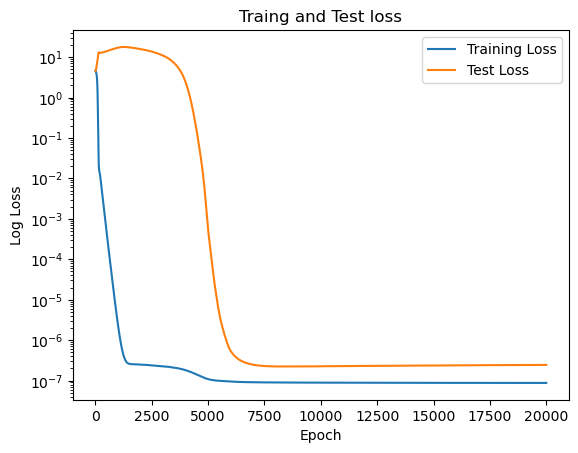

In [147]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()

## Training with Orthograd instead
In the paper https://arxiv.org/abs/2501.04697, the authors showed basically that the delay in generalization is due to the network following a "naive loss minimization" strategy by scaling the logits, which in return leads to an absorption error in the softmax which stops the training. The logits are scaled by simply scaling all the weights of the network (which works since it is approx. homogeneous). As fix, they suggest projecting the gradient to the subspace orthogonal to the direction of the weights.

The following code which does the orthogonal projection of the gradient is also from this paper.

In [ ]:
class OrthoGrad(t.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls=t.optim.SGD):
        """
        A wrapper optimizer that projects gradients to be orthogonal
        to the current parameters before performing an update.
        Args:
            params (iterable): Parameter groups to optimize
            base_optimizer_cls (Optimizer class): The base optimizer class
                (e.g., torch.optim.SGD, torch.optim.AdamW).
        """
        # Minimal defaults for OrthoGrad itself (nothing special needed).
        defaults = {}
        super().__init__(params, defaults)
        # Create the wrapped/base optimizer using *our* param_groups.
        self.base_optimizer = base_optimizer_cls(self.param_groups)

    @staticmethod
    def _orthogonalize_gradients(params):
        """
        Projects the gradient g to be orthogonal to the current weights w.
        g_orth = g - ( (w·g)/(w·w + eps) ) * w
        And then re-scales g_orth to have the same norm as g.
        """
        with t.no_grad():
            for p in params:
                if p.grad is not None:
                    w = p.view(-1)
                    g = p.grad.view(-1)

                    w_norm_sq = t.dot(w, w) + 1e-30
                    proj = t.dot(w, g) / w_norm_sq
                    g_orth = g - proj * w

                    g_norm = g.norm(2)
                    g_orth_norm = g_orth.norm(2) + 1e-30
                    g_orth_scaled = g_orth * (g_norm / g_orth_norm)

                    p.grad.copy_(g_orth_scaled.view_as(p.grad))

    def step(self, closure=None):
        for group in self.param_groups:
            self._orthogonalize_gradients(group['params'])
        return self.base_optimizer.step(closure)

def get_optimizer(model, lr,optimizer,beta2,orthogonal_gradients,weight_decay,adam_epsilon):

    param_group = dict(params=model.parameters())

    if optimizer in ("Adam", "AdamW"):
        param_group |= dict(lr=lr, betas=(0.9, beta2), eps=adam_epsilon)
    elif optimizer == "SGD":
        param_group |= dict(lr=lr, momentum=0.8 if orthogonal_gradients else 0.2)
    else:
        raise ValueError(f'Unsupported optimizer type: {optimizer}')

    param_group |= dict(weight_decay=weight_decay)
    base_optimizer_cls = getattr(optim, optimizer)

    if orthogonal_gradients:
        optimizer = OrthoGrad([param_group], base_optimizer_cls)
    else:
        optimizer = base_optimizer_cls([param_group])

    return optimizer

In [ ]:
lr = 1e-3
weight_decay = 0.
optimizer = "AdamW"
beta2 = 0.98
orthogoal_gradients = True
adam_epsilon = 1e-8

model_ortho = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)
optimizer_ortho = get_optimizer(model_ortho, lr,optimizer,beta2,orthogoal_gradients,weight_decay,adam_epsilon)

In [ ]:
train_losses_ortho = []
test_losses_ortho = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model_ortho(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses_ortho.append(train_loss.item())
    optimizer_ortho.step()
    optimizer_ortho.zero_grad()
    with t.inference_mode():
        test_logits = model_ortho(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses_ortho.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 101/10000 [00:09<15:02, 10.97it/s]

Epoch 99 Train Loss 2.49433670167115 Test loss 6.969461133367866


  2%|▏         | 201/10000 [00:18<15:12, 10.74it/s]

Epoch 199 Train Loss 0.0998236826548971 Test loss 4.834650650912399


  3%|▎         | 301/10000 [00:27<14:09, 11.41it/s]

Epoch 299 Train Loss 0.005210148332024914 Test loss 2.519393540978759


  4%|▍         | 401/10000 [00:36<14:05, 11.35it/s]

Epoch 399 Train Loss 0.0009193714360459748 Test loss 1.4700323528934138


  5%|▌         | 501/10000 [00:44<13:51, 11.43it/s]

Epoch 499 Train Loss 0.00019886711224771756 Test loss 0.8881048749551367


  6%|▌         | 601/10000 [00:53<13:51, 11.30it/s]

Epoch 599 Train Loss 4.523446464392589e-05 Test loss 0.5363559310366297


  7%|▋         | 701/10000 [01:02<14:11, 10.92it/s]

Epoch 699 Train Loss 1.0682350684668862e-05 Test loss 0.3162303580535751


  8%|▊         | 801/10000 [01:11<13:25, 11.42it/s]

Epoch 799 Train Loss 2.727939631947375e-06 Test loss 0.18458388167014475


  9%|▉         | 901/10000 [01:20<14:39, 10.35it/s]

Epoch 899 Train Loss 7.778370978794352e-07 Test loss 0.10916757253306361


 10%|█         | 1001/10000 [01:29<13:41, 10.96it/s]

Epoch 999 Train Loss 2.442144909521593e-07 Test loss 0.06466251590942884


 11%|█         | 1101/10000 [01:38<12:55, 11.47it/s]

Epoch 1099 Train Loss 8.451481886455029e-08 Test loss 0.039314020064079816


 12%|█▏        | 1201/10000 [01:47<13:47, 10.64it/s]

Epoch 1199 Train Loss 3.3013486463578725e-08 Test loss 0.024129518904757535


 13%|█▎        | 1301/10000 [01:56<12:38, 11.47it/s]

Epoch 1299 Train Loss 1.4975826154746486e-08 Test loss 0.01533641815377078


 14%|█▍        | 1401/10000 [02:05<12:25, 11.54it/s]

Epoch 1399 Train Loss 8.011207016064148e-09 Test loss 0.010440127594341693


 15%|█▌        | 1501/10000 [02:14<12:16, 11.54it/s]

Epoch 1499 Train Loss 4.98160351476086e-09 Test loss 0.007582592230455592


 16%|█▌        | 1601/10000 [02:23<13:00, 10.76it/s]

Epoch 1599 Train Loss 3.4740058159429654e-09 Test loss 0.005832521435357167


 17%|█▋        | 1702/10000 [17:33<34:10,  4.05it/s]     

Epoch 1699 Train Loss 2.6248189782472755e-09 Test loss 0.0047198499826174994


 18%|█▊        | 1801/10000 [17:42<13:17, 10.28it/s]

Epoch 1799 Train Loss 2.0963095914230433e-09 Test loss 0.003951376757645032


 19%|█▉        | 1901/10000 [17:52<12:31, 10.78it/s]

Epoch 1899 Train Loss 1.7402910905060409e-09 Test loss 0.003401351096455481


 20%|██        | 2001/10000 [18:01<12:27, 10.71it/s]

Epoch 1999 Train Loss 1.4853087351329637e-09 Test loss 0.002984962051154898


 21%|██        | 2101/10000 [31:29<39:43,  3.31it/s]     

Epoch 2099 Train Loss 1.293910479070873e-09 Test loss 0.002661242258839399


 22%|██▏       | 2201/10000 [31:55<2:15:57,  1.05s/it]

Epoch 2199 Train Loss 1.1453399346213334e-09 Test loss 0.002409151713983753


 23%|██▎       | 2301/10000 [35:44<1:37:00,  1.32it/s] 

Epoch 2299 Train Loss 1.0267093727192152e-09 Test loss 0.002207303206608698


 24%|██▍       | 2402/10000 [48:23<14:28,  8.75it/s]     

Epoch 2399 Train Loss 9.298177028484806e-10 Test loss 0.0020368392147500115


 25%|██▌       | 2501/10000 [49:41<11:49, 10.58it/s]   

Epoch 2499 Train Loss 8.492551355636844e-10 Test loss 0.0018920658120821173


 26%|██▌       | 2601/10000 [49:50<12:14, 10.08it/s]

Epoch 2599 Train Loss 7.812796917182393e-10 Test loss 0.0017675810839635625


 27%|██▋       | 2701/10000 [50:00<10:56, 11.12it/s]

Epoch 2699 Train Loss 7.23101461907986e-10 Test loss 0.0016611827046008412


 28%|██▊       | 2802/10000 [50:11<09:53, 12.14it/s]

Epoch 2799 Train Loss 6.727451285235707e-10 Test loss 0.001568084893951121


 29%|██▉       | 2902/10000 [50:20<09:47, 12.07it/s]

Epoch 2899 Train Loss 6.288064736207862e-10 Test loss 0.0014862093718870733


 30%|███       | 3002/10000 [50:29<10:37, 10.98it/s]

Epoch 2999 Train Loss 5.901127319565065e-10 Test loss 0.0014133269325594274


 31%|███       | 3102/10000 [50:37<09:48, 11.72it/s]

Epoch 3099 Train Loss 5.55774995482646e-10 Test loss 0.0013464110091916629


 32%|███▏      | 3202/10000 [50:46<10:07, 11.19it/s]

Epoch 3199 Train Loss 5.251151487908175e-10 Test loss 0.0012868157507726393


 33%|███▎      | 3302/10000 [50:55<09:49, 11.37it/s]

Epoch 3299 Train Loss 4.975699312074079e-10 Test loss 0.0012321335562591191


 34%|███▍      | 3402/10000 [51:04<09:59, 11.01it/s]

Epoch 3399 Train Loss 4.726826545776494e-10 Test loss 0.0011834276023874825


 35%|███▌      | 3502/10000 [51:13<09:44, 11.12it/s]

Epoch 3499 Train Loss 4.5010414313890595e-10 Test loss 0.0011387774108474532


 36%|███▌      | 3602/10000 [51:22<09:35, 11.11it/s]

Epoch 3599 Train Loss 4.2952232492367227e-10 Test loss 0.001097745256387683


 37%|███▋      | 3702/10000 [51:31<08:49, 11.89it/s]

Epoch 3699 Train Loss 4.106971714456768e-10 Test loss 0.0010592922061515655


 38%|███▊      | 3802/10000 [51:39<09:06, 11.35it/s]

Epoch 3799 Train Loss 3.9341532349091287e-10 Test loss 0.0010233751214103087


 39%|███▉      | 3902/10000 [51:48<09:10, 11.07it/s]

Epoch 3899 Train Loss 3.774984980473769e-10 Test loss 0.0009897053993305875


 40%|████      | 4002/10000 [51:57<09:09, 10.91it/s]

Epoch 3999 Train Loss 3.627986332234785e-10 Test loss 0.0009580419376929381


 41%|████      | 4102/10000 [52:06<09:03, 10.85it/s]

Epoch 4099 Train Loss 3.491765682679241e-10 Test loss 0.0009281608708326442


 42%|████▏     | 4202/10000 [52:15<08:18, 11.64it/s]

Epoch 4199 Train Loss 3.365136846239572e-10 Test loss 0.0009001468088778799


 43%|████▎     | 4302/10000 [52:24<08:26, 11.24it/s]

Epoch 4299 Train Loss 3.247132754142885e-10 Test loss 0.0008737296022807094


 44%|████▍     | 4402/10000 [52:33<08:23, 11.12it/s]

Epoch 4399 Train Loss 3.1369025939392714e-10 Test loss 0.0008490612347476399


 45%|████▌     | 4502/10000 [52:42<08:07, 11.28it/s]

Epoch 4499 Train Loss 3.0337075196820863e-10 Test loss 0.0008257807645902681


 46%|████▌     | 4602/10000 [52:51<07:56, 11.32it/s]

Epoch 4599 Train Loss 2.936893035622097e-10 Test loss 0.0008035702672854296


 47%|████▋     | 4702/10000 [53:00<07:57, 11.09it/s]

Epoch 4699 Train Loss 2.8458941830181686e-10 Test loss 0.000782321779729502


 48%|████▊     | 4802/10000 [53:09<07:40, 11.30it/s]

Epoch 4799 Train Loss 2.760089502140561e-10 Test loss 0.0007620737219163288


 49%|████▉     | 4902/10000 [53:18<07:31, 11.29it/s]

Epoch 4899 Train Loss 2.6791804342690826e-10 Test loss 0.0007424786978532811


 50%|█████     | 5002/10000 [53:27<07:28, 11.15it/s]

Epoch 4999 Train Loss 2.6027614466427856e-10 Test loss 0.0007240131288047539


 51%|█████     | 5102/10000 [53:36<07:18, 11.16it/s]

Epoch 5099 Train Loss 2.5304203475233463e-10 Test loss 0.0007072387089620137


 52%|█████▏    | 5201/10000 [53:46<07:10, 11.16it/s]

Epoch 5199 Train Loss 2.4618959362898733e-10 Test loss 0.0006906405615134919


 53%|█████▎    | 5302/10000 [53:55<06:59, 11.20it/s]

Epoch 5299 Train Loss 2.396883232081551e-10 Test loss 0.0006745092344565308


 54%|█████▍    | 5402/10000 [54:04<06:56, 11.03it/s]

Epoch 5399 Train Loss 2.335134795220711e-10 Test loss 0.0006590931125893355


 55%|█████▌    | 5502/10000 [54:13<06:56, 10.79it/s]

Epoch 5499 Train Loss 2.2763879489857358e-10 Test loss 0.0006444001444624032


 56%|█████▌    | 5602/10000 [54:22<06:37, 11.05it/s]

Epoch 5599 Train Loss 2.2204547179052392e-10 Test loss 0.0006303576019263596


 57%|█████▋    | 5700/10000 [54:31<07:12,  9.95it/s]

Epoch 5699 Train Loss 2.167161763196821e-10 Test loss 0.0006166829267152132


 58%|█████▊    | 5802/10000 [54:40<06:19, 11.06it/s]

Epoch 5799 Train Loss 2.1162937582460382e-10 Test loss 0.0006037242375958651


 59%|█████▉    | 5902/10000 [54:50<06:06, 11.18it/s]

Epoch 5899 Train Loss 2.0676791645471937e-10 Test loss 0.0005911575926883481


 60%|██████    | 6002/10000 [54:59<06:01, 11.07it/s]

Epoch 5999 Train Loss 2.0212034481569897e-10 Test loss 0.000578837725687428


 61%|██████    | 6102/10000 [55:08<05:51, 11.10it/s]

Epoch 6099 Train Loss 1.9767117978775562e-10 Test loss 0.0005670194994469019


 62%|██████▏   | 6202/10000 [55:17<05:44, 11.01it/s]

Epoch 6199 Train Loss 1.9340881981568679e-10 Test loss 0.0005557490188137916


 63%|██████▎   | 6300/10000 [55:26<05:58, 10.31it/s]

Epoch 6299 Train Loss 1.8932064463007987e-10 Test loss 0.0005447287855794837


 64%|██████▍   | 6402/10000 [55:35<05:27, 10.97it/s]

Epoch 6399 Train Loss 1.8539686499089323e-10 Test loss 0.0005341814975622504


 65%|██████▌   | 6502/10000 [55:44<04:59, 11.69it/s]

Epoch 6499 Train Loss 1.8162717549486044e-10 Test loss 0.0005241001995446322


 66%|██████▌   | 6602/10000 [55:53<05:05, 11.12it/s]

Epoch 6599 Train Loss 1.7800203742993647e-10 Test loss 0.0005143568069858713


 67%|██████▋   | 6702/10000 [56:02<05:00, 10.98it/s]

Epoch 6699 Train Loss 1.7451492518688085e-10 Test loss 0.0005048231095376138


 68%|██████▊   | 6802/10000 [56:11<04:44, 11.23it/s]

Epoch 6799 Train Loss 1.7115896576915996e-10 Test loss 0.000495601222407587


 69%|██████▉   | 6902/10000 [56:20<04:47, 10.79it/s]

Epoch 6899 Train Loss 1.6792598168785758e-10 Test loss 0.00048661983217756767


 70%|███████   | 7002/10000 [56:29<04:28, 11.18it/s]

Epoch 6999 Train Loss 1.6480828848434896e-10 Test loss 0.00047791962207254055


 71%|███████   | 7102/10000 [56:38<04:20, 11.12it/s]

Epoch 7099 Train Loss 1.6180201674420695e-10 Test loss 0.00046935214828563174


 72%|███████▏  | 7202/10000 [56:47<04:12, 11.09it/s]

Epoch 7199 Train Loss 1.5889868864390516e-10 Test loss 0.0004612340089141991


 73%|███████▎  | 7301/10000 [56:56<04:00, 11.22it/s]

Epoch 7299 Train Loss 1.560954465590798e-10 Test loss 0.00045343533538403085


 74%|███████▍  | 7401/10000 [57:06<04:04, 10.63it/s]

Epoch 7399 Train Loss 1.5338664739369732e-10 Test loss 0.00044592182375831693


 75%|███████▌  | 7501/10000 [57:15<03:44, 11.12it/s]

Epoch 7499 Train Loss 1.507684328276871e-10 Test loss 0.0004387209076384077


 76%|███████▌  | 7601/10000 [57:24<03:36, 11.09it/s]

Epoch 7599 Train Loss 1.4823514505121836e-10 Test loss 0.0004317570273000031


 77%|███████▋  | 7701/10000 [57:33<03:28, 11.02it/s]

Epoch 7699 Train Loss 1.4578308468472471e-10 Test loss 0.00042493143780620386


 78%|███████▊  | 7801/10000 [57:42<03:21, 10.90it/s]

Epoch 7799 Train Loss 1.4340828112689848e-10 Test loss 0.00041828280602115603


 79%|███████▉  | 7901/10000 [57:51<03:09, 11.10it/s]

Epoch 7899 Train Loss 1.4110607663414574e-10 Test loss 0.0004117925077402453


 80%|████████  | 8001/10000 [58:00<03:01, 11.01it/s]

Epoch 7999 Train Loss 1.3887488557823242e-10 Test loss 0.00040563653333296624


 81%|████████  | 8101/10000 [58:09<02:52, 11.02it/s]

Epoch 8099 Train Loss 1.367112577699761e-10 Test loss 0.0003995952555309668


 82%|████████▏ | 8201/10000 [58:18<02:41, 11.11it/s]

Epoch 8199 Train Loss 1.3461014739916686e-10 Test loss 0.00039376437338189155


 83%|████████▎ | 8301/10000 [58:27<02:32, 11.14it/s]

Epoch 8299 Train Loss 1.3257144635478832e-10 Test loss 0.00038798851511542614


 84%|████████▍ | 8401/10000 [58:36<02:26, 10.94it/s]

Epoch 8399 Train Loss 1.3059263629537377e-10 Test loss 0.0003824156294775062


 85%|████████▌ | 8501/10000 [58:45<02:14, 11.16it/s]

Epoch 8499 Train Loss 1.2866942559127147e-10 Test loss 0.00037702456035930144


 86%|████████▌ | 8601/10000 [58:54<02:02, 11.41it/s]

Epoch 8599 Train Loss 1.268008291260916e-10 Test loss 0.00037169589509224545


 87%|████████▋ | 8701/10000 [59:03<01:55, 11.23it/s]

Epoch 8699 Train Loss 1.2498440315024765e-10 Test loss 0.0003665365596769012


 88%|████████▊ | 8801/10000 [59:12<01:46, 11.28it/s]

Epoch 8799 Train Loss 1.2321748871500446e-10 Test loss 0.0003614512405403273


 89%|████████▉ | 8901/10000 [59:21<01:40, 10.97it/s]

Epoch 8899 Train Loss 1.2149897882335794e-10 Test loss 0.00035653536114913826


 90%|█████████ | 9001/10000 [59:30<01:30, 11.07it/s]

Epoch 8999 Train Loss 1.1982611522810077e-10 Test loss 0.00035172561075369127


 91%|█████████ | 9101/10000 [59:40<01:20, 11.14it/s]

Epoch 9099 Train Loss 1.181952891142792e-10 Test loss 0.0003469023353986134


 92%|█████████▏| 9201/10000 [59:49<01:11, 11.15it/s]

Epoch 9199 Train Loss 1.166071259363812e-10 Test loss 0.0003422848263304438


 93%|█████████▎| 9301/10000 [59:58<01:03, 11.08it/s]

Epoch 9299 Train Loss 1.150598464262817e-10 Test loss 0.00033785373948063134


 94%|█████████▍| 9401/10000 [1:00:07<00:53, 11.13it/s]

Epoch 9399 Train Loss 1.1355235019638453e-10 Test loss 0.0003334838818333059


 95%|█████████▌| 9501/10000 [1:00:16<00:45, 11.02it/s]

Epoch 9499 Train Loss 1.1208294476637505e-10 Test loss 0.0003288713956336311


 96%|█████████▌| 9601/10000 [1:00:25<00:35, 11.22it/s]

Epoch 9599 Train Loss 1.1065037364075584e-10 Test loss 0.0003244430532577599


 97%|█████████▋| 9701/10000 [1:00:34<00:27, 10.96it/s]

Epoch 9699 Train Loss 1.0925321784277188e-10 Test loss 0.00032014379003027005


 98%|█████████▊| 9801/10000 [1:00:43<00:18, 11.01it/s]

Epoch 9799 Train Loss 1.0789029924560914e-10 Test loss 0.00031600870691309984


 99%|█████████▉| 9902/10000 [1:00:52<00:08, 11.11it/s]

Epoch 9899 Train Loss 1.0656020595402027e-10 Test loss 0.00031200888797886585


100%|██████████| 10000/10000 [1:01:01<00:00,  2.73it/s]

Epoch 9999 Train Loss 1.0526108977320666e-10 Test loss 0.000308072873718711


In [ ]:
print(train_losses_ortho)

[4.632420038871681, 4.5918414052808405, 4.576953334068216, 4.570277016708376, 4.564112240609464, 4.557146215109135, 4.549958148686731, 4.543138123847747, 4.5366111583553606, 4.530169666756731, 4.52347083055826, 4.516427665117814, 4.508978009577815, 4.5011820890262495, 4.493072001996621, 4.4846227409783515, 4.475735065318686, 4.466266156335975, 4.456172965107057, 4.445517968783095, 4.434250780631692, 4.422339224101285, 4.409796994700354, 4.396548417823389, 4.382710160106736, 4.368299435522457, 4.353352018007906, 4.337903265437918, 4.32200286711236, 4.305600324379358, 4.288738374129205, 4.271490684400207, 4.253852535189546, 4.235930815089566, 4.217853977787011, 4.1996160222204635, 4.181283417479351, 4.1628710290263475, 4.14436569321273, 4.1257509650257695, 4.107058079019469, 4.088290099194472, 4.069356166228662, 4.050246058853954, 4.031007631752158, 4.011680618799173, 3.99225621266403, 3.972671095439648, 3.9528798559682383, 3.932890471176982, 3.912630300019275, 3.8920958688445544, 3.8712

In [ ]:
plt.plot(train_losses_ortho,label="Training Loss")
plt.plot(test_losses_ortho,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss with using Ortho-grad and no weight decay")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Reverse Engineering
The goal is to look at the learned weights of the network and try to reverse engineer what the network is doing.

In [148]:
import scipy

### Embedding

In [149]:
W_E = model.embed.W_E.detach().numpy()
print(W_E.shape)

(128, 98)


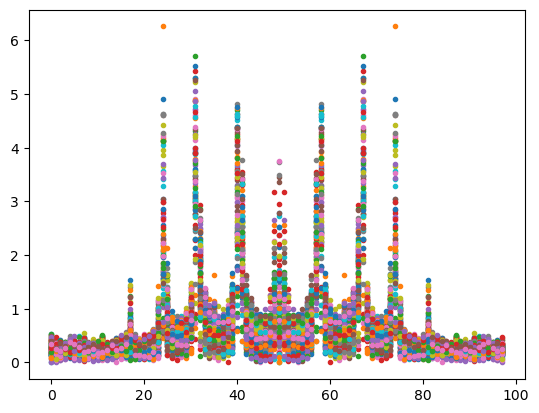

In [162]:
#Plot the first 3 Embedding vectors that are fourier transformed and we look at the absolute value. 
avg_amp = np.zeros(shape=(p+1))
for i in range(p):
    x = W_E[i,:]
    x = np.abs(scipy.fft.fft(x))
    avg_amp += x
    plt.plot(x,".")
avg_amp = avg_amp / (p+1)
plt.show()

List of key frequencies:  [24 31 32 40 41 48 49 50 57 58 66 67 74]


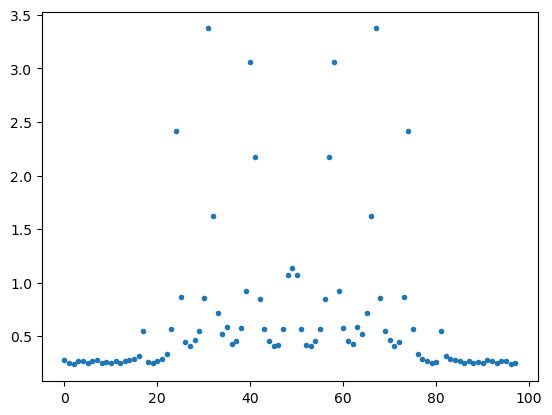

In [173]:
plt.plot(avg_amp,".")
key_freq = np.argwhere(avg_amp > 1).T[0]

print("List of key frequencies: ",key_freq)


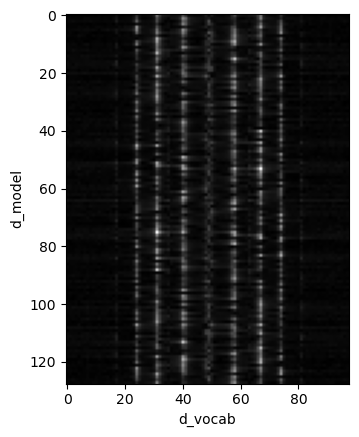

In [159]:
x = scipy.fft.fft2(W_E)
x = np.absolute(x)
max_x = np.max(x)
x = x/max_x
plt.imshow(x,cmap="grey")
plt.xlabel("d_vocab")
plt.ylabel("d_model")
plt.show()

Notably there are a few frequencies that are mainly contributing to the signal. But I am slightly confused about the dimension in thich this happens. W_E is d_model x d_vocab dimensional, so for a given input a the embedded vector is W_E[:,a]

It is also interesting to note that the pattern is symmetrical along the d_vocab dimension.

In [23]:
a = 24
b = 1
tokens = t.tensor([[a,b,p],[a,b,p]])
embed_a = model.embed(tokens)[0,0].detach().numpy()
plt.plot(embed_a)

NameError: name 'model' is not defined

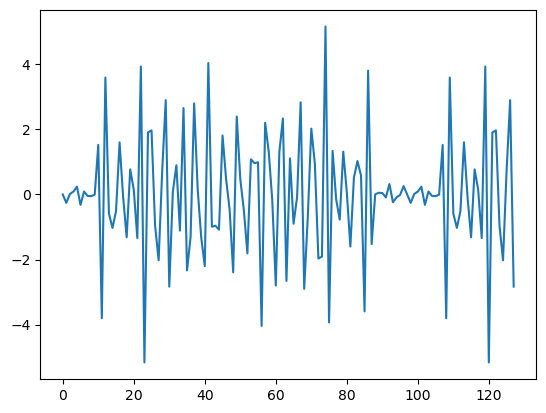

In [187]:

model_ax = np.arange(d_model)
synth_embed = np.zeros(shape=(d_model))
for w in key_freq:
    synth_embed += np.sin((2*np.pi/p)*w*model_ax)
plt.plot(synth_embed)

## Training a simpler version and check if it groks

In [24]:
a = 1
b = 1
tokens = t.tensor([[a,b,p],[a,b,p]])
x = model.embed(tokens)
x = einops.rearrange(x,"b p d -> b (p d)")
print(x.shape)
print(d_model*n_ctx)

NameError: name 'model' is not defined

In [8]:
n_ctx = 2

In [9]:
from models.one_layer_transformer import SimpleMLP

In [10]:
simpleMLP = SimpleMLP(d_model=d_model,d_vocab=d_vocab,n_ctx=n_ctx,act_type="ReLU")
# Define optimizer
optimizer = t.optim.AdamW(simpleMLP.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [11]:
import torch as t

In [12]:
x = simpleMLP.embed(train_dataset)
x = einops.rearrange(x,"b p d -> b (p d)")
print(simpleMLP.mlp_without_ctx.d_in)
x = t.einsum("b d, m d -> b m",x,simpleMLP.mlp_without_ctx.W_in)
print(x.shape)

256
torch.Size([2822, 512])


In [13]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = simpleMLP(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with t.inference_mode():
        test_logits = simpleMLP(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  0%|          | 0/20000 [00:00<?, ?it/s]

  1%|          | 103/20000 [00:03<10:06, 32.83it/s]

Epoch 99 Train Loss 0.8872159894995433 Test loss 8.915823879428341


  1%|          | 203/20000 [00:06<10:11, 32.39it/s]

Epoch 199 Train Loss 0.028727633765652256 Test loss 12.516638624136123


  2%|▏         | 303/20000 [00:09<09:57, 32.95it/s]

Epoch 299 Train Loss 0.009159385970764837 Test loss 13.010964549399867


  2%|▏         | 404/20000 [00:12<10:13, 31.93it/s]

Epoch 399 Train Loss 0.0030221968489861422 Test loss 13.60595383360138


  3%|▎         | 505/20000 [00:15<10:02, 32.36it/s]

Epoch 499 Train Loss 0.001023628207912019 Test loss 14.242071405764824


  3%|▎         | 605/20000 [00:19<10:03, 32.14it/s]

Epoch 599 Train Loss 0.0003536107452984801 Test loss 14.917506329080704


  4%|▎         | 705/20000 [00:22<09:55, 32.41it/s]

Epoch 699 Train Loss 0.0001243273365113725 Test loss 15.607974702101455


  4%|▍         | 805/20000 [00:25<10:04, 31.76it/s]

Epoch 799 Train Loss 4.47744222290066e-05 Test loss 16.290628638641554


  5%|▍         | 905/20000 [00:28<09:51, 32.30it/s]

Epoch 899 Train Loss 1.6808682290956503e-05 Test loss 16.956093040226534


  5%|▌         | 1005/20000 [00:31<09:42, 32.64it/s]

Epoch 999 Train Loss 6.791201316118455e-06 Test loss 17.57321158298423


  6%|▌         | 1105/20000 [00:34<09:35, 32.85it/s]

Epoch 1099 Train Loss 3.108979263900084e-06 Test loss 18.093721042871042


  6%|▌         | 1204/20000 [00:37<11:33, 27.08it/s]

Epoch 1199 Train Loss 1.6968407500825154e-06 Test loss 18.46942318658255


  7%|▋         | 1305/20000 [00:40<09:34, 32.54it/s]

Epoch 1299 Train Loss 1.1405353401653775e-06 Test loss 18.665341403867757


  7%|▋         | 1405/20000 [00:44<09:35, 32.30it/s]

Epoch 1399 Train Loss 9.345127577391859e-07 Test loss 18.68224510194435


  8%|▊         | 1504/20000 [00:47<10:28, 29.45it/s]

Epoch 1499 Train Loss 8.737352662787796e-07 Test loss 18.58148462806756


  8%|▊         | 1603/20000 [00:50<09:24, 32.62it/s]

Epoch 1599 Train Loss 8.622222279852733e-07 Test loss 18.434370272912407


  9%|▊         | 1703/20000 [00:53<09:20, 32.65it/s]

Epoch 1699 Train Loss 8.625240892957151e-07 Test loss 18.278276586860535


  9%|▉         | 1803/20000 [00:56<09:22, 32.35it/s]

Epoch 1799 Train Loss 8.639137563172911e-07 Test loss 18.124001629858267


 10%|▉         | 1903/20000 [00:59<09:17, 32.44it/s]

Epoch 1899 Train Loss 8.642348971574031e-07 Test loss 17.97226119162324


 10%|█         | 2003/20000 [01:02<09:21, 32.08it/s]

Epoch 1999 Train Loss 8.635176165486569e-07 Test loss 17.823128308087153


 11%|█         | 2103/20000 [01:05<09:17, 32.08it/s]

Epoch 2099 Train Loss 8.620442326497863e-07 Test loss 17.676156362851962


 11%|█         | 2203/20000 [01:08<09:07, 32.49it/s]

Epoch 2199 Train Loss 8.600824550392035e-07 Test loss 17.53063413140169


 12%|█▏        | 2303/20000 [01:12<09:09, 32.21it/s]

Epoch 2299 Train Loss 8.577655659986675e-07 Test loss 17.385581306942495


 12%|█▏        | 2403/20000 [01:15<09:05, 32.24it/s]

Epoch 2399 Train Loss 8.55317851576395e-07 Test loss 17.24091164588531


 13%|█▎        | 2503/20000 [01:18<08:57, 32.55it/s]

Epoch 2499 Train Loss 8.526789284784561e-07 Test loss 17.09548960157508


 13%|█▎        | 2603/20000 [01:21<09:02, 32.07it/s]

Epoch 2599 Train Loss 8.499708187165587e-07 Test loss 16.94884855701542


 14%|█▎        | 2703/20000 [01:24<09:10, 31.43it/s]

Epoch 2699 Train Loss 8.473654634813369e-07 Test loss 16.801692408440367


 14%|█▍        | 2803/20000 [01:27<08:53, 32.25it/s]

Epoch 2799 Train Loss 8.447631123637895e-07 Test loss 16.652923390979712


 15%|█▍        | 2903/20000 [01:30<09:32, 29.84it/s]

Epoch 2899 Train Loss 8.421434527720976e-07 Test loss 16.50479669369684


 15%|█▌        | 3003/20000 [01:33<08:49, 32.10it/s]

Epoch 2999 Train Loss 8.395331422475216e-07 Test loss 16.35249654522731


 16%|█▌        | 3103/20000 [01:37<08:49, 31.90it/s]

Epoch 3099 Train Loss 8.368002086203669e-07 Test loss 16.19568830036785


 16%|█▌        | 3203/20000 [01:40<08:52, 31.53it/s]

Epoch 3199 Train Loss 8.341479498639928e-07 Test loss 16.035205024963666


 17%|█▋        | 3303/20000 [01:43<08:42, 31.95it/s]

Epoch 3299 Train Loss 8.31685013952757e-07 Test loss 15.8725644012421


 17%|█▋        | 3403/20000 [01:46<08:39, 31.94it/s]

Epoch 3399 Train Loss 8.292287751081283e-07 Test loss 15.708135423986757


 18%|█▊        | 3503/20000 [01:49<08:33, 32.11it/s]

Epoch 3499 Train Loss 8.267374984975353e-07 Test loss 15.539320895499111


 18%|█▊        | 3603/20000 [01:52<08:52, 30.80it/s]

Epoch 3599 Train Loss 8.244112732884098e-07 Test loss 15.3700672918468


 19%|█▊        | 3703/20000 [01:56<08:29, 32.00it/s]

Epoch 3699 Train Loss 8.217306656285014e-07 Test loss 15.195204182450084


 19%|█▉        | 3803/20000 [01:59<08:26, 32.01it/s]

Epoch 3799 Train Loss 8.190722150760721e-07 Test loss 15.012427337274389


 20%|█▉        | 3903/20000 [02:02<08:27, 31.71it/s]

Epoch 3899 Train Loss 8.163287971871207e-07 Test loss 14.824241801194646


 20%|██        | 4003/20000 [02:05<08:19, 32.02it/s]

Epoch 3999 Train Loss 8.135923278134505e-07 Test loss 14.628050763250037


 21%|██        | 4103/20000 [02:08<08:14, 32.15it/s]

Epoch 4099 Train Loss 8.107298375379009e-07 Test loss 14.423127146240503


 21%|██        | 4203/20000 [02:11<08:25, 31.25it/s]

Epoch 4199 Train Loss 8.078394508244454e-07 Test loss 14.211598565959267


 22%|██▏       | 4303/20000 [02:14<08:11, 31.92it/s]

Epoch 4299 Train Loss 8.048506091405018e-07 Test loss 13.990103931576543


 22%|██▏       | 4403/20000 [02:18<08:06, 32.07it/s]

Epoch 4399 Train Loss 8.016709239266825e-07 Test loss 13.759833859147019


 23%|██▎       | 4503/20000 [02:21<08:02, 32.10it/s]

Epoch 4499 Train Loss 7.986996375361336e-07 Test loss 13.522190802025545


 23%|██▎       | 4603/20000 [02:24<07:58, 32.18it/s]

Epoch 4599 Train Loss 7.952706197445271e-07 Test loss 13.273681627686083


 24%|██▎       | 4705/20000 [02:27<08:18, 30.69it/s]

Epoch 4699 Train Loss 7.918370444956243e-07 Test loss 13.01409443914709


 24%|██▍       | 4805/20000 [02:31<07:51, 32.20it/s]

Epoch 4799 Train Loss 7.884773515604479e-07 Test loss 12.741813193372973


 25%|██▍       | 4905/20000 [17:34<51:48,  4.86it/s]    

Epoch 4899 Train Loss 7.852091546655944e-07 Test loss 12.46128723784841


 25%|██▌       | 5004/20000 [17:37<07:43, 32.36it/s]

Epoch 4999 Train Loss 7.81723808795399e-07 Test loss 12.172913102497443


 26%|██▌       | 5104/20000 [17:40<07:40, 32.38it/s]

Epoch 5099 Train Loss 7.783042711560286e-07 Test loss 11.87856800560222


 26%|██▌       | 5206/20000 [17:44<07:46, 31.70it/s]

Epoch 5199 Train Loss 7.747371585026934e-07 Test loss 11.578743569282933


 27%|██▋       | 5306/20000 [17:47<07:57, 30.77it/s]

Epoch 5299 Train Loss 7.709795056169273e-07 Test loss 11.268411282205713


 27%|██▋       | 5406/20000 [17:50<08:02, 30.26it/s]

Epoch 5399 Train Loss 7.674575726700207e-07 Test loss 10.951612909372093


 28%|██▊       | 5506/20000 [17:53<07:39, 31.53it/s]

Epoch 5499 Train Loss 7.637419239362956e-07 Test loss 10.627431601905808


 28%|██▊       | 5606/20000 [17:57<07:30, 31.95it/s]

Epoch 5599 Train Loss 7.602369748302933e-07 Test loss 10.297994824266766


 29%|██▊       | 5706/20000 [18:00<07:25, 32.10it/s]

Epoch 5699 Train Loss 7.564121338686941e-07 Test loss 9.963582471091499


 29%|██▉       | 5806/20000 [18:03<07:21, 32.17it/s]

Epoch 5799 Train Loss 7.526019520545289e-07 Test loss 9.625972929835946


 30%|██▉       | 5905/20000 [18:29<33:10,  7.08it/s]  

Epoch 5899 Train Loss 7.486929238514881e-07 Test loss 9.282819300537529


 30%|███       | 6004/20000 [18:33<07:10, 32.52it/s]

Epoch 5999 Train Loss 7.446273375309501e-07 Test loss 8.935961069792627


 31%|███       | 6106/20000 [18:36<07:16, 31.84it/s]

Epoch 6099 Train Loss 7.404193972867525e-07 Test loss 8.580889374342178


 31%|███       | 6206/20000 [18:39<06:53, 33.39it/s]

Epoch 6199 Train Loss 7.364254663201779e-07 Test loss 8.223184085621192


 32%|███▏      | 6306/20000 [18:42<06:50, 33.35it/s]

Epoch 6299 Train Loss 7.317872256031906e-07 Test loss 7.860703466386903


 32%|███▏      | 6402/20000 [18:45<06:56, 32.63it/s]

Epoch 6399 Train Loss 7.269803902017057e-07 Test loss 7.489742361544337


 33%|███▎      | 6504/20000 [20:13<08:06, 27.76it/s]   

Epoch 6499 Train Loss 7.21947841017873e-07 Test loss 7.111232693170435


 33%|███▎      | 6604/20000 [20:17<08:05, 27.61it/s]

Epoch 6599 Train Loss 7.166600225115329e-07 Test loss 6.72384408502596


 34%|███▎      | 6705/20000 [20:20<06:50, 32.36it/s]

Epoch 6699 Train Loss 7.112237537791309e-07 Test loss 6.325028911520261


 34%|███▍      | 6805/20000 [20:23<06:54, 31.86it/s]

Epoch 6799 Train Loss 7.055544837920592e-07 Test loss 5.92086582773689


 35%|███▍      | 6905/20000 [20:26<06:51, 31.85it/s]

Epoch 6899 Train Loss 6.993741387709532e-07 Test loss 5.508995631972663


 35%|███▌      | 7005/20000 [20:29<06:47, 31.89it/s]

Epoch 6999 Train Loss 6.927169146279266e-07 Test loss 5.087815656825669


 36%|███▌      | 7105/20000 [20:33<06:43, 31.99it/s]

Epoch 7099 Train Loss 6.858795336540342e-07 Test loss 4.661731196923163


 36%|███▌      | 7205/20000 [20:36<07:00, 30.40it/s]

Epoch 7199 Train Loss 6.785732743049851e-07 Test loss 4.2308399191883375


 37%|███▋      | 7304/20000 [20:39<06:43, 31.47it/s]

Epoch 7299 Train Loss 6.702909705932061e-07 Test loss 3.7932546879624827


 37%|███▋      | 7404/20000 [20:42<06:35, 31.87it/s]

Epoch 7399 Train Loss 6.616927395822865e-07 Test loss 3.354655081611618


 38%|███▊      | 7504/20000 [20:45<06:33, 31.75it/s]

Epoch 7499 Train Loss 6.522430032784653e-07 Test loss 2.918042049440041


 38%|███▊      | 7604/20000 [20:48<06:25, 32.15it/s]

Epoch 7599 Train Loss 6.421046438304943e-07 Test loss 2.487228829425377


 39%|███▊      | 7704/20000 [20:52<06:38, 30.83it/s]

Epoch 7699 Train Loss 6.3137990347181e-07 Test loss 2.0721754063474966


 39%|███▉      | 7804/20000 [20:55<06:26, 31.57it/s]

Epoch 7799 Train Loss 6.202891688269624e-07 Test loss 1.6831682797119576


 40%|███▉      | 7904/20000 [20:58<06:37, 30.44it/s]

Epoch 7899 Train Loss 6.086359439114839e-07 Test loss 1.328934695909399


 40%|████      | 8003/20000 [21:01<06:19, 31.65it/s]

Epoch 7999 Train Loss 5.96745662422933e-07 Test loss 1.018239307526164


 41%|████      | 8103/20000 [21:04<06:15, 31.68it/s]

Epoch 8099 Train Loss 5.846786045838728e-07 Test loss 0.7555108409038265


 41%|████      | 8201/20000 [21:08<06:10, 31.82it/s]

Epoch 8199 Train Loss 5.722054827467249e-07 Test loss 0.5430392456918046


 42%|████▏     | 8306/20000 [21:11<06:25, 30.36it/s]

Epoch 8299 Train Loss 5.598424315450162e-07 Test loss 0.37733546887638764


 42%|████▏     | 8405/20000 [21:14<06:01, 32.05it/s]

Epoch 8399 Train Loss 5.470860294394184e-07 Test loss 0.2535141893714055


 43%|████▎     | 8505/20000 [21:17<06:00, 31.85it/s]

Epoch 8499 Train Loss 5.343553488896368e-07 Test loss 0.16455307979784117


 43%|████▎     | 8605/20000 [21:21<06:00, 31.59it/s]

Epoch 8599 Train Loss 5.21106688286857e-07 Test loss 0.10242499982374054


 44%|████▎     | 8705/20000 [21:24<05:53, 31.94it/s]

Epoch 8699 Train Loss 5.076188157566941e-07 Test loss 0.06074536368776324


 44%|████▍     | 8803/20000 [21:27<05:53, 31.72it/s]

Epoch 8799 Train Loss 4.937449075760902e-07 Test loss 0.03392759267645227


 45%|████▍     | 8903/20000 [21:30<05:51, 31.55it/s]

Epoch 8899 Train Loss 4.798964220200302e-07 Test loss 0.017566717798109803


 45%|████▌     | 9003/20000 [21:33<05:47, 31.68it/s]

Epoch 8999 Train Loss 4.6580844592046767e-07 Test loss 0.008246224295262838


 46%|████▌     | 9103/20000 [21:37<05:39, 32.13it/s]

Epoch 9099 Train Loss 4.520349339202021e-07 Test loss 0.003431972999836584


 46%|████▌     | 9203/20000 [21:40<05:41, 31.64it/s]

Epoch 9199 Train Loss 4.393330500675675e-07 Test loss 0.0012798111542916837


 47%|████▋     | 9303/20000 [21:43<05:36, 31.79it/s]

Epoch 9299 Train Loss 4.2756027387247785e-07 Test loss 0.0004490061218010647


 47%|████▋     | 9403/20000 [21:46<05:31, 31.93it/s]

Epoch 9399 Train Loss 4.1710752848520947e-07 Test loss 0.00016152241934632762


 48%|████▊     | 9503/20000 [21:49<05:31, 31.71it/s]

Epoch 9499 Train Loss 4.079881219762746e-07 Test loss 6.551816789462472e-05


 48%|████▊     | 9605/20000 [21:53<05:39, 30.64it/s]

Epoch 9599 Train Loss 4.0011417905928015e-07 Test loss 3.100877364707102e-05


 49%|████▊     | 9705/20000 [21:56<05:25, 31.62it/s]

Epoch 9699 Train Loss 3.93126234846837e-07 Test loss 1.695372376317936e-05


 49%|████▉     | 9805/20000 [21:59<05:18, 32.01it/s]

Epoch 9799 Train Loss 3.869438122763721e-07 Test loss 1.0419939438476565e-05


 50%|████▉     | 9905/20000 [22:02<05:19, 31.61it/s]

Epoch 9899 Train Loss 3.8154166918106243e-07 Test loss 7.029580722860537e-06


 50%|█████     | 10005/20000 [22:05<05:13, 31.92it/s]

Epoch 9999 Train Loss 3.7682967319132537e-07 Test loss 5.096242648853416e-06


 51%|█████     | 10105/20000 [22:08<05:14, 31.51it/s]

Epoch 10099 Train Loss 3.726534579173871e-07 Test loss 3.908649966947551e-06


 51%|█████     | 10205/20000 [22:12<05:12, 31.37it/s]

Epoch 10199 Train Loss 3.6899094331208373e-07 Test loss 3.1330486099727394e-06


 52%|█████▏    | 10305/20000 [22:15<05:02, 32.01it/s]

Epoch 10299 Train Loss 3.658050269869408e-07 Test loss 2.597995905353837e-06


 52%|█████▏    | 10405/20000 [22:18<05:02, 31.72it/s]

Epoch 10399 Train Loss 3.629763080726175e-07 Test loss 2.214296557250521e-06


 53%|█████▎    | 10505/20000 [22:21<05:00, 31.60it/s]

Epoch 10499 Train Loss 3.60475396459605e-07 Test loss 1.9306059092946814e-06


 53%|█████▎    | 10605/20000 [22:24<04:57, 31.57it/s]

Epoch 10599 Train Loss 3.582129150505121e-07 Test loss 1.7131965097495821e-06


 54%|█████▎    | 10705/20000 [22:27<04:55, 31.50it/s]

Epoch 10699 Train Loss 3.5618835858424234e-07 Test loss 1.5423247569770147e-06


 54%|█████▍    | 10805/20000 [22:31<04:49, 31.71it/s]

Epoch 10799 Train Loss 3.54356740355609e-07 Test loss 1.4047245851953868e-06


 55%|█████▍    | 10904/20000 [22:34<04:45, 31.86it/s]

Epoch 10899 Train Loss 3.5264252467334695e-07 Test loss 1.29337808375956e-06


 55%|█████▌    | 11004/20000 [22:37<04:44, 31.64it/s]

Epoch 10999 Train Loss 3.510636291722171e-07 Test loss 1.2013010809804353e-06


 56%|█████▌    | 11104/20000 [22:40<04:41, 31.55it/s]

Epoch 11099 Train Loss 3.495723445565116e-07 Test loss 1.1250237727127455e-06


 56%|█████▌    | 11204/20000 [22:43<04:38, 31.61it/s]

Epoch 11199 Train Loss 3.481696053352278e-07 Test loss 1.0599350298279958e-06


 57%|█████▋    | 11304/20000 [22:47<04:33, 31.80it/s]

Epoch 11299 Train Loss 3.4681497714521096e-07 Test loss 1.0032769416676262e-06


 57%|█████▋    | 11404/20000 [22:50<04:35, 31.23it/s]

Epoch 11399 Train Loss 3.454919133236792e-07 Test loss 9.53758319598832e-07


 58%|█████▊    | 11504/20000 [22:53<04:31, 31.27it/s]

Epoch 11499 Train Loss 3.4420169111643084e-07 Test loss 9.097695901972743e-07


 58%|█████▊    | 11604/20000 [22:56<04:25, 31.68it/s]

Epoch 11599 Train Loss 3.4289449849648305e-07 Test loss 8.706837243964859e-07


 59%|█████▊    | 11704/20000 [22:59<04:21, 31.68it/s]

Epoch 11699 Train Loss 3.415781561107965e-07 Test loss 8.354389562420829e-07


 59%|█████▉    | 11803/20000 [23:03<04:19, 31.55it/s]

Epoch 11799 Train Loss 3.4024470436476187e-07 Test loss 8.03521677962794e-07


 60%|█████▉    | 11903/20000 [23:06<04:17, 31.44it/s]

Epoch 11899 Train Loss 3.389006488363735e-07 Test loss 7.747586456638693e-07


 60%|██████    | 12003/20000 [23:09<04:13, 31.53it/s]

Epoch 11999 Train Loss 3.3755983650498733e-07 Test loss 7.482208289824046e-07


 61%|██████    | 12103/20000 [23:12<04:13, 31.17it/s]

Epoch 12099 Train Loss 3.361367230411183e-07 Test loss 7.234159694181721e-07


 61%|██████    | 12203/20000 [23:15<04:20, 29.93it/s]

Epoch 12199 Train Loss 3.347042715302819e-07 Test loss 7.001624412496246e-07


 62%|██████▏   | 12303/20000 [23:19<04:05, 31.37it/s]

Epoch 12299 Train Loss 3.3325494202368323e-07 Test loss 6.784269989813301e-07


 62%|██████▏   | 12403/20000 [23:22<04:00, 31.55it/s]

Epoch 12399 Train Loss 3.317449841326953e-07 Test loss 6.579735895749804e-07


 63%|██████▎   | 12503/20000 [23:25<03:56, 31.67it/s]

Epoch 12499 Train Loss 3.3018348819414404e-07 Test loss 6.389500381241169e-07


 63%|██████▎   | 12603/20000 [23:28<03:54, 31.52it/s]

Epoch 12599 Train Loss 3.286176668375607e-07 Test loss 6.210584032071547e-07


 64%|██████▎   | 12703/20000 [23:31<03:50, 31.70it/s]

Epoch 12699 Train Loss 3.26989431378137e-07 Test loss 6.03977723471551e-07


 64%|██████▍   | 12803/20000 [23:35<03:46, 31.71it/s]

Epoch 12799 Train Loss 3.2532453047698413e-07 Test loss 5.882667636472761e-07


 65%|██████▍   | 12903/20000 [23:38<03:44, 31.58it/s]

Epoch 12899 Train Loss 3.236218170690232e-07 Test loss 5.735682530826444e-07


 65%|██████▌   | 13003/20000 [23:41<03:42, 31.49it/s]

Epoch 12999 Train Loss 3.219140071665425e-07 Test loss 5.597223928320227e-07


 66%|██████▌   | 13103/20000 [23:44<03:43, 30.85it/s]

Epoch 13099 Train Loss 3.201915681939032e-07 Test loss 5.469089386371165e-07


 66%|██████▌   | 13203/20000 [23:47<03:34, 31.73it/s]

Epoch 13199 Train Loss 3.1847252329616254e-07 Test loss 5.350818454750586e-07


 67%|██████▋   | 13303/20000 [23:51<03:32, 31.55it/s]

Epoch 13299 Train Loss 3.167982694892837e-07 Test loss 5.242001877201984e-07


 67%|██████▋   | 13403/20000 [23:54<03:28, 31.59it/s]

Epoch 13399 Train Loss 3.1517659637221035e-07 Test loss 5.142731961679673e-07


 68%|██████▊   | 13503/20000 [23:57<03:27, 31.34it/s]

Epoch 13499 Train Loss 3.136007612857351e-07 Test loss 5.051306159721222e-07


 68%|██████▊   | 13603/20000 [24:00<03:37, 29.35it/s]

Epoch 13599 Train Loss 3.121004003412129e-07 Test loss 4.96768962741593e-07


 69%|██████▊   | 13705/20000 [24:03<03:20, 31.47it/s]

Epoch 13699 Train Loss 3.106713671239707e-07 Test loss 4.890512615861928e-07


 69%|██████▉   | 13805/20000 [24:07<03:18, 31.14it/s]

Epoch 13799 Train Loss 3.0932156320082645e-07 Test loss 4.818898871621288e-07


 70%|██████▉   | 13905/20000 [24:10<03:15, 31.22it/s]

Epoch 13899 Train Loss 3.0805148072314514e-07 Test loss 4.7532160955086524e-07


 70%|███████   | 14004/20000 [24:13<03:13, 31.02it/s]

Epoch 13999 Train Loss 3.0687074676346494e-07 Test loss 4.692615242561398e-07


 71%|███████   | 14105/20000 [24:17<03:15, 30.16it/s]

Epoch 14099 Train Loss 3.057752515062751e-07 Test loss 4.636105798708627e-07


 71%|███████   | 14203/20000 [24:20<03:07, 30.88it/s]

Epoch 14199 Train Loss 3.0476755209123875e-07 Test loss 4.585087440693933e-07


 72%|███████▏  | 14303/20000 [24:23<02:58, 31.99it/s]

Epoch 14299 Train Loss 3.038580474781906e-07 Test loss 4.5389772999247414e-07


 72%|███████▏  | 14403/20000 [24:26<02:54, 32.01it/s]

Epoch 14399 Train Loss 3.030404065205297e-07 Test loss 4.497412361591192e-07


 73%|███████▎  | 14506/20000 [24:29<02:59, 30.58it/s]

Epoch 14499 Train Loss 3.0231122734113507e-07 Test loss 4.459948982269825e-07


 73%|███████▎  | 14605/20000 [24:33<03:06, 28.97it/s]

Epoch 14599 Train Loss 3.0167553934170495e-07 Test loss 4.4259024832214314e-07


 74%|███████▎  | 14705/20000 [24:36<02:47, 31.70it/s]

Epoch 14699 Train Loss 3.0110056218020974e-07 Test loss 4.3945109110573885e-07


 74%|███████▍  | 14805/20000 [24:39<02:45, 31.38it/s]

Epoch 14799 Train Loss 3.0061214232020993e-07 Test loss 4.3659889428694834e-07


 75%|███████▍  | 14905/20000 [24:42<02:42, 31.37it/s]

Epoch 14899 Train Loss 3.0018559368199794e-07 Test loss 4.3394844719142e-07


 75%|███████▌  | 15005/20000 [24:45<02:37, 31.71it/s]

Epoch 14999 Train Loss 2.9980410462033785e-07 Test loss 4.315332227641727e-07


 76%|███████▌  | 15105/20000 [24:49<02:35, 31.57it/s]

Epoch 15099 Train Loss 2.994620786467829e-07 Test loss 4.2927704280856236e-07


 76%|███████▌  | 15205/20000 [24:52<02:32, 31.52it/s]

Epoch 15199 Train Loss 2.991486930619612e-07 Test loss 4.2713535038044254e-07


 77%|███████▋  | 15305/20000 [24:55<02:28, 31.65it/s]

Epoch 15299 Train Loss 2.9886725763170074e-07 Test loss 4.251382774012809e-07


 77%|███████▋  | 15405/20000 [24:58<02:28, 30.95it/s]

Epoch 15399 Train Loss 2.9860386247899143e-07 Test loss 4.2330326186737763e-07


 78%|███████▊  | 15505/20000 [25:01<02:21, 31.69it/s]

Epoch 15499 Train Loss 2.9835785321557663e-07 Test loss 4.2156068956607104e-07


 78%|███████▊  | 15605/20000 [25:04<02:17, 31.99it/s]

Epoch 15599 Train Loss 2.981205733406374e-07 Test loss 4.199869735923041e-07


 79%|███████▊  | 15705/20000 [25:08<02:15, 31.70it/s]

Epoch 15699 Train Loss 2.9789261011089077e-07 Test loss 4.1852474504646486e-07


 79%|███████▉  | 15804/20000 [25:11<02:23, 29.26it/s]

Epoch 15799 Train Loss 2.976778314908157e-07 Test loss 4.1724166205393206e-07


 80%|███████▉  | 15906/20000 [25:14<02:09, 31.50it/s]

Epoch 15899 Train Loss 2.974666433386338e-07 Test loss 4.160693500349025e-07


 80%|████████  | 16006/20000 [25:17<02:05, 31.81it/s]

Epoch 15999 Train Loss 2.9726682273822275e-07 Test loss 4.149546200837664e-07


 81%|████████  | 16106/20000 [25:21<02:03, 31.45it/s]

Epoch 16099 Train Loss 2.970781633195256e-07 Test loss 4.139483059134542e-07


 81%|████████  | 16206/20000 [25:24<02:01, 31.35it/s]

Epoch 16199 Train Loss 2.9689059874956334e-07 Test loss 4.1294332109491726e-07


 82%|████████▏ | 16306/20000 [25:27<01:56, 31.68it/s]

Epoch 16299 Train Loss 2.967059311193851e-07 Test loss 4.1203877494623096e-07


 82%|████████▏ | 16406/20000 [25:30<01:54, 31.43it/s]

Epoch 16399 Train Loss 2.965236019607414e-07 Test loss 4.1116048955014675e-07


 83%|████████▎ | 16506/20000 [25:33<01:51, 31.25it/s]

Epoch 16499 Train Loss 2.9634765653825693e-07 Test loss 4.103721772013666e-07


 83%|████████▎ | 16605/20000 [25:36<01:48, 31.32it/s]

Epoch 16599 Train Loss 2.961740226645472e-07 Test loss 4.0962774181946267e-07


 84%|████████▎ | 16705/20000 [25:40<01:44, 31.63it/s]

Epoch 16699 Train Loss 2.960059214815725e-07 Test loss 4.08923523670168e-07


 84%|████████▍ | 16805/20000 [25:43<01:41, 31.56it/s]

Epoch 16799 Train Loss 2.958389223755278e-07 Test loss 4.082032881739017e-07


 85%|████████▍ | 16905/20000 [25:46<01:38, 31.41it/s]

Epoch 16899 Train Loss 2.9567983873330835e-07 Test loss 4.075307988672611e-07


 85%|████████▌ | 17005/20000 [25:49<01:35, 31.28it/s]

Epoch 16999 Train Loss 2.955196497901021e-07 Test loss 4.068946548253381e-07


 86%|████████▌ | 17105/20000 [25:53<01:31, 31.47it/s]

Epoch 17099 Train Loss 2.9536034881590397e-07 Test loss 4.062623342020892e-07


 86%|████████▌ | 17204/20000 [25:56<01:27, 31.80it/s]

Epoch 17199 Train Loss 2.9520745793375313e-07 Test loss 4.056736320786485e-07


 87%|████████▋ | 17304/20000 [25:59<01:26, 31.24it/s]

Epoch 17299 Train Loss 2.950540177210676e-07 Test loss 4.0507216169931915e-07


 87%|████████▋ | 17404/20000 [26:02<01:22, 31.37it/s]

Epoch 17399 Train Loss 2.949091916181831e-07 Test loss 4.0454392277366664e-07


 88%|████████▊ | 17505/20000 [26:05<01:19, 31.25it/s]

Epoch 17499 Train Loss 2.9476396108644675e-07 Test loss 4.0403618885972187e-07


 88%|████████▊ | 17606/20000 [26:09<01:16, 31.37it/s]

Epoch 17599 Train Loss 2.946195393204842e-07 Test loss 4.035186676836061e-07


 89%|████████▊ | 17705/20000 [26:12<01:12, 31.63it/s]

Epoch 17699 Train Loss 2.9447906660826513e-07 Test loss 4.0304223566614583e-07


 89%|████████▉ | 17805/20000 [26:15<01:09, 31.67it/s]

Epoch 17799 Train Loss 2.9434244604567673e-07 Test loss 4.0262002457277794e-07


 90%|████████▉ | 17905/20000 [26:18<01:07, 31.01it/s]

Epoch 17899 Train Loss 2.942086843273301e-07 Test loss 4.0221750947986436e-07


 90%|█████████ | 18005/20000 [26:22<01:03, 31.21it/s]

Epoch 17999 Train Loss 2.940763013406988e-07 Test loss 4.0178784809768236e-07


 91%|█████████ | 18105/20000 [26:25<01:00, 31.41it/s]

Epoch 18099 Train Loss 2.9394671960354556e-07 Test loss 4.0135783910080585e-07


 91%|█████████ | 18205/20000 [26:28<00:57, 31.33it/s]

Epoch 18199 Train Loss 2.9381823710223977e-07 Test loss 4.009809042429298e-07


 92%|█████████▏| 18305/20000 [26:31<00:53, 31.39it/s]

Epoch 18299 Train Loss 2.936930978387085e-07 Test loss 4.006291000472425e-07


 92%|█████████▏| 18405/20000 [26:34<00:50, 31.50it/s]

Epoch 18399 Train Loss 2.935682049401165e-07 Test loss 4.003131087688415e-07


 93%|█████████▎| 18505/20000 [26:38<00:47, 31.37it/s]

Epoch 18499 Train Loss 2.934461340316427e-07 Test loss 4.00002109639343e-07


 93%|█████████▎| 18605/20000 [26:41<00:45, 30.87it/s]

Epoch 18599 Train Loss 2.9332542700810635e-07 Test loss 3.996960087171224e-07


 94%|█████████▎| 18705/20000 [26:44<00:41, 31.42it/s]

Epoch 18699 Train Loss 2.9320533048946536e-07 Test loss 3.9939877137286616e-07


 94%|█████████▍| 18805/20000 [26:47<00:39, 30.64it/s]

Epoch 18799 Train Loss 2.930879259571494e-07 Test loss 3.9908144047444224e-07


 95%|█████████▍| 18905/20000 [26:50<00:36, 29.69it/s]

Epoch 18899 Train Loss 2.9297128195710636e-07 Test loss 3.98785289926659e-07


 95%|█████████▌| 19004/20000 [26:54<00:31, 31.44it/s]

Epoch 18999 Train Loss 2.9285396433477597e-07 Test loss 3.9848975343285186e-07


 96%|█████████▌| 19104/20000 [26:57<00:28, 31.41it/s]

Epoch 19099 Train Loss 2.927389022016737e-07 Test loss 3.9819469933761033e-07


 96%|█████████▌| 19204/20000 [27:00<00:25, 31.20it/s]

Epoch 19199 Train Loss 2.9262815315544554e-07 Test loss 3.979263960804118e-07


 97%|█████████▋| 19303/20000 [27:03<00:22, 31.35it/s]

Epoch 19299 Train Loss 2.9251877125285476e-07 Test loss 3.9763226996424597e-07


 97%|█████████▋| 19403/20000 [27:06<00:19, 31.36it/s]

Epoch 19399 Train Loss 2.9241275308198674e-07 Test loss 3.9736793055505357e-07


 98%|█████████▊| 19503/20000 [27:10<00:15, 31.34it/s]

Epoch 19499 Train Loss 2.9230741498820093e-07 Test loss 3.9710482345002855e-07


 98%|█████████▊| 19603/20000 [27:13<00:12, 31.10it/s]

Epoch 19599 Train Loss 2.922043417466892e-07 Test loss 3.9686757492613573e-07


 99%|█████████▊| 19703/20000 [27:16<00:09, 31.32it/s]

Epoch 19699 Train Loss 2.921010726954465e-07 Test loss 3.966648625716839e-07


 99%|█████████▉| 19803/20000 [27:19<00:06, 31.48it/s]

Epoch 19799 Train Loss 2.9199856709285706e-07 Test loss 3.9646657924271923e-07


100%|█████████▉| 19903/20000 [27:23<00:03, 31.41it/s]

Epoch 19899 Train Loss 2.9189707332552644e-07 Test loss 3.9628522053522125e-07


100%|██████████| 20000/20000 [27:26<00:00, 12.15it/s]

Epoch 19999 Train Loss 2.91798664387206e-07 Test loss 3.961188427717043e-07


In [18]:
import scipy
import matplotlib.pyplot as plt

(128, 98)
(512, 256)


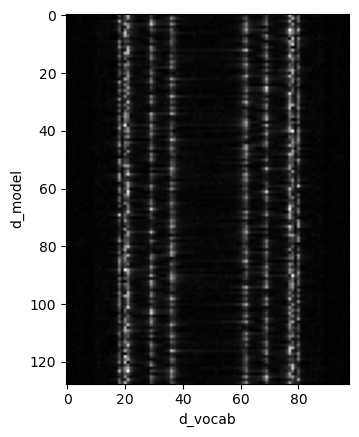

In [60]:
W_E = simpleMLP.embed.W_E.detach().numpy()
#between the embedding and the preactivations of the mlp there is no linearity, so we can combine the lingear operations for both tokens
W_in = simpleMLP.mlp_without_ctx.W_in.detach().numpy()
W_a = W_in[:,:d_model] @ W_E
W_b = W_in[:,d_model:] @ W_E
x = W_E
print(W_E.shape)
print(W_in.shape)
x = scipy.fft.fft2(x)
x = np.absolute(x)
max_x = np.max(x)
x = x/max_x
plt.imshow(x,cmap="grey")
plt.xlabel("d_vocab")
plt.ylabel("d_model")
plt.show()

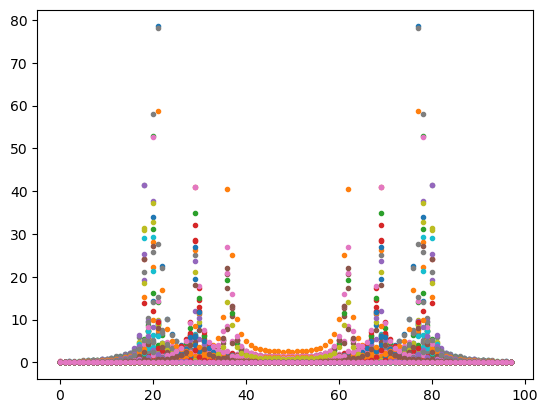

In [46]:
#Plot the Embedding vectors that are fourier transformed and we look at the absolute value. 
avg_amp = np.zeros(shape=(p+1))
for i in range(p):
    x = W_a[i,:]
    x = np.abs(scipy.fft.fft(x))
    avg_amp += x
    plt.plot(x,".")
avg_amp = avg_amp / (p+1)
plt.show()

List of key frequencies:  [18 19 20 21 29 30 36 62 68 69 77 78 79 80]


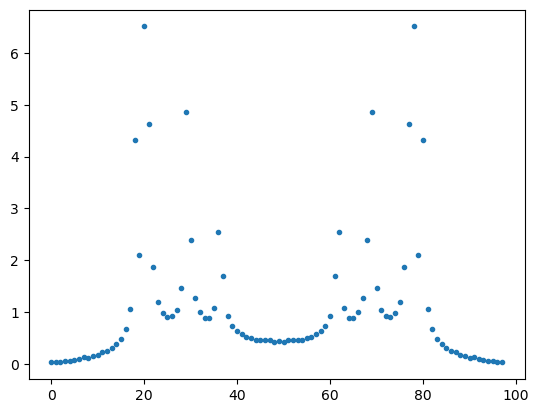

In [47]:
plt.plot(avg_amp,".")
key_freq = np.argwhere(avg_amp > 2).T[0]
print("List of key frequencies: ",key_freq)

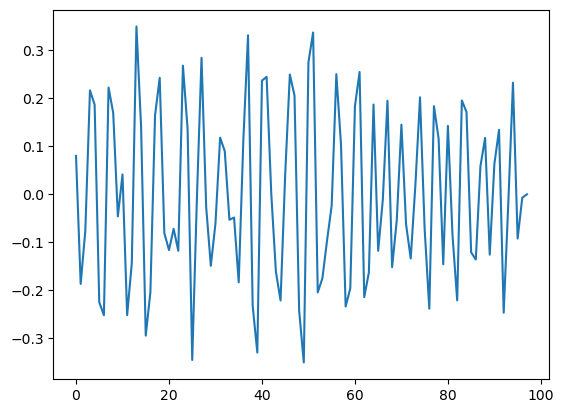

In [69]:

embed_a = W_E[0,:]
embed_a_ft = np.absolute(scipy.fft.fft(embed_a))
plt.plot(embed_a)
#plt.plot(embed_a_ft)
plt.show()


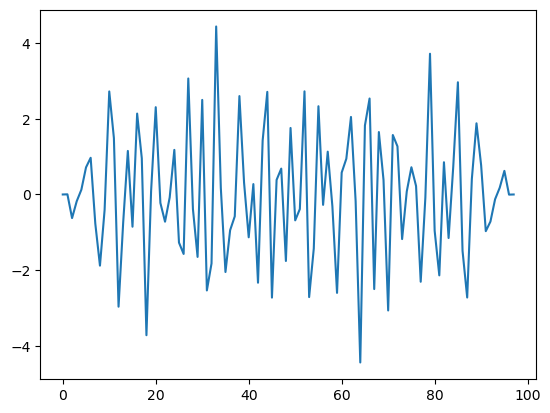

In [70]:

model_ax = np.arange(d_vocab)
synth_embed = np.zeros(shape=(d_vocab))
for w in key_freq:
    synth_embed += np.sin((2*np.pi/p)*w*model_ax)
plt.plot(synth_embed)